In [1]:
# ================================================================
# 01_preprocess.py  –  Pré-processamento diário (versão peso em gramas)
# ------------------------------------------------------------
# Este script lê o arquivo Excel `datasets/dados.xlsx`, aplica
# validações robustas, trata outliers e gera os 15 indicadores
# diários exigidos pelo projeto. Agora o peso é convertido de kg
# para gramas (`peso_g`). As razões por kg continuam corretas ao
# dividir `peso_g` por 1 000.
# ------------------------------------------------------------
# Como usar (terminal macOS, já com venv ativo):
#   python src/01_preprocess.py
# ------------------------------------------------------------
# Requisitos: pandas, numpy, pyarrow, openpyxl, tqdm (opcional)
# Instalação sugerida (brew + pip):
#   brew install pyarrow
#   pip install pandas numpy openpyxl tqdm
# ================================================================

!pip install tensorflow tensorflow-probability pandas numpy matplotlib networkx openpyxl pyarrow tqdm keras

from __future__ import annotations

import sys
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Configurações básicas
# -----------------------------------------------------------------

DATA_PATH = Path("dados.xlsx")  # input
OUTPUT_PATH = Path("dados_diarios_preproc.parquet")  # output

# Colunas mínimas que o pipeline não pode rodar sem
REQUIRED_COLS = {
    "data", "peso_kg",
    "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade",
    "passos", "minutos_em_pe",
    "fc_repouso_bpm", "hrv_medio",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Colunas que não podem ter valores negativos
NON_NEGATIVE = {
    "peso_kg", "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade", "passos", "minutos_em_pe",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Quantis usados para winsorização
QUANT_LOW, QUANT_HIGH = 0.05, 0.95

# -----------------------------------------------------------------
# 2. Funções utilitárias
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê o Excel, normaliza nomes de colunas e remove duplicatas.

    - `strip()` espaços iniciais/finais
    - converte a `snake_case` mínima (lower)
    - se nomes repetirem, mantém somente a primeira ocorrência
    """
    df = pd.read_excel(path, engine="openpyxl")

    # normaliza cabeçalhos
    new_cols = []
    seen = set()
    for raw in df.columns:
        col = str(raw).strip()
        col = col.replace(" ", "_").lower()
        if col in seen:
            warnings.warn(
                f"Coluna duplicada encontrada e ignorada: '{col}'. Somente a primeira ocorrência será usada.",
                RuntimeWarning,
            )
            continue
        new_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = new_cols
    return df


def winsorize(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Aplica winsorização p5–p95 inplace para as colunas fornecidas."""
    for col in tqdm(cols, desc="Winsorizando", leave=False):
        lo, hi = df[col].quantile([QUANT_LOW, QUANT_HIGH], interpolation="linear")
        df[col] = df[col].clip(lo, hi)
    return df

# -----------------------------------------------------------------
# 3. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not DATA_PATH.exists():
        sys.exit(f"❌ Arquivo de dados não encontrado em {DATA_PATH.resolve()}")

    print("📥  Lendo planilha…")
    df = read_excel_unique(DATA_PATH)

    # ----- validação de colunas essenciais -----
    missing = sorted(REQUIRED_COLS - set(df.columns))
    if missing:
        sys.exit(f"❌ Faltando colunas obrigatórias: {missing}")

    # ----- normalização de tipos & valores impossíveis -----
    print("🧹  Ajustando tipos e valores…")
    df["data"] = pd.to_datetime(df["data"], errors="coerce")

    for col in NON_NEGATIVE & set(df.columns):
        df.loc[df[col] < 0, col] = np.nan

    # ----- converte peso para gramas e remove peso_kg -----
    df["peso_g"] = df["peso_kg"] * 1000.0  # precisão em gramas
    df.drop(columns="peso_kg", inplace=True)

    # ----- winsorização p5–p95 -----
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    winsorize(df, numeric_cols)

    # -----------------------------------------------------------------
    # 4. Cálculo dos indicadores
    # -----------------------------------------------------------------
    print("🧮  Calculando indicadores…")

    df_ind = pd.DataFrame()
    df_ind["data"] = df["data"]

    # cópias diretas
    df_ind["Fat_pct_mean"]          = df["gordura_pct"]
    df_ind["Circumference_cm_med"] = df["circunferencia_cm"]
    df_ind["Total_kcal_mean"]       = df["energia_total"]
    df_ind["Steps_mean"]            = df["passos"]
    df_ind["RestingHR_mean"]        = df["fc_repouso_bpm"]
    df_ind["HRV_mean"]              = df["hrv_medio"]
    df_ind["SleepDur_mean"]         = df["duracao_sono_min"]
    df_ind["Water_ml_mean"]         = df["agua_consumida_ml"]

    # derivadas / razões
    df_ind["Lean_to_Fat_ratio"]       = df["massa_magra_pct"] / df["gordura_pct"]
    df_ind["Activity_kcal_fraction"]  = df["energia_atividade"] / df["energia_total"]
    df_ind["Standing_minutes_raw"]    = df["minutos_em_pe"]  # para desvio-padrão futuro
    df_ind["DeepFrac_mean"]           = df["minutos_deep"] / df["duracao_sono_min"]

    # razões por kg – dividimos peso em gramas por 1000
    kg_denominator = df["peso_g"] / 1000.0
    df_ind["Carb_per_kg_mean"]        = df["carboidratos_g"] / kg_denominator
    df_ind["Protein_per_kg_mean"]     = df["proteinas_g"] / kg_denominator

    # déficit calórico permanece igual
    df_ind["Cal_deficit_mean"]        = df["calorias_consumidas"] - df["energia_total"]

    # ----- salva parquet -----
    print("💾  Gravando Parquet…")
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_ind.sort_values("data").to_parquet(OUTPUT_PATH, index=False, engine="pyarrow")

    # resumo rápido
    print("\n✅  Pré-processamento concluído!")
    print(f"Arquivo salvo em: {OUTPUT_PATH.resolve()}")
    print("\nResumo numérico (pós-winsor):")
    print(df_ind.describe().loc[["mean", "std", "min", "max"]].round(2))


if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


📥  Lendo planilha…
🧹  Ajustando tipos e valores…


🧮  Calculando indicadores…
💾  Gravando Parquet…



✅  Pré-processamento concluído!
Arquivo salvo em: /content/dados_diarios_preproc.parquet

Resumo numérico (pós-winsor):
                     data  Fat_pct_mean  Circumference_cm_med  \
mean  2026-05-15 12:00:00         20.04                 79.93   
std                   NaN          1.78                  4.43   
min   2025-01-01 00:00:00         16.90                 72.09   
max   2027-09-27 00:00:00         23.30                 88.10   

      Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  \
mean          2002.13     7453.53           62.05     50.13         481.06   
std            112.16     2510.73            4.34      8.70          23.26   
min           1800.95     3514.00           55.00     35.20         441.00   
max           2213.10    11471.70           69.00     66.20         523.00   

      Water_ml_mean  Lean_to_Fat_ratio  Activity_kcal_fraction  \
mean        2241.66               3.78                    0.30   
std          420.80           

WIndows cons

In [2]:
# ================================================================
# 02_window_construction.py – Construção das janelas de 91 dias
# ------------------------------------------------------------
# Pipeline comentado linha a linha:
#   1. Lê o parquet diário com 15 indicadores + peso em gramas.
#   2. Anexa o peso (g) para cada dia a partir do Excel.
#   3. Desliza janelas de 91 dias (step = 7).
#   4. Agrega indicadores (média, mediana, desvio‑padrão).
#   5. Calcula o alvo: inclinação da reta peso × tempo (kg/sem).
#   6. Salva o resultado em Parquet para uso no BSTS.
# ------------------------------------------------------------
# Execução (terminal macOS):
#   python src/02_window_construction.py
# ------------------------------------------------------------
# Dependências: pandas, numpy, pyarrow, openpyxl, tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Caminhos e parâmetros
# -----------------------------------------------------------------

DAILY_PARQUET = Path("dados_diarios_preproc.parquet")
EXCEL_SOURCE = Path("dados.xlsx")
WINDOW_PARQUET = Path("janelas_91d.parquet")

WINDOW_SIZE = 91   # dias na janela
STEP_SIZE = 7      # deslocamento

# -----------------------------------------------------------------
# 2. Leitura defensiva do Excel (sem colunas duplicadas)
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê Excel, normaliza cabeçalhos e descarta colunas duplicadas."""
    df = pd.read_excel(path, engine="openpyxl")

    norm_cols, seen = [], set()
    for raw in df.columns:
        col = str(raw).strip().replace(" ", "_").lower()
        if col in seen:
            warnings.warn(f"Coluna duplicada ignorada: {col}")
            continue
        norm_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = norm_cols
    return df

# -----------------------------------------------------------------
# 3. Funções de agregação por janela
# -----------------------------------------------------------------

def slope_kg_per_week(sub: pd.DataFrame) -> float:
    """Inclinação da reta de peso (kg/semana) dentro de uma janela."""
    y = sub["peso_g"].values / 1000.0  # g → kg
    if np.isnan(y).any():
        return np.nan
    x = np.arange(len(sub))            # 0..90
    slope_day = np.polyfit(x, y, 1)[0] # kg/dia
    return slope_day * 7               # kg/semana


def aggregate_window(sub: pd.DataFrame) -> dict:
    """Calcula métricas da janela (mean, median, std) + alvo."""
    out: dict[str, float] = {}

    # --- médias (11) ---
    mean_cols = {
        "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
        "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
        "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    }
    for c in mean_cols:
        out[c] = sub[c].mean()

    # --- mediana (1) ---
    out["Circumference_cm_med"] = sub["Circumference_cm_med"].median()

    # --- desvio‑padrão (1) ---
    out["Standing_variability"] = sub["Standing_minutes_raw"].std()

    # --- razões por kg (2) ---
    out["Carb_per_kg_mean"]    = sub["Carb_per_kg_mean"].mean()
    out["Protein_per_kg_mean"] = sub["Protein_per_kg_mean"].mean()

    # --- alvo ---
    out["slope_kg_per_week"] = slope_kg_per_week(sub)
    return out


def generate_windows(df: pd.DataFrame) -> pd.DataFrame:
    """Gera DataFrame final: 1 linha por janela deslizante."""
    records = []
    starts = range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE)
    for i in tqdm(starts, desc="Gerando janelas"):
        sub = df.iloc[i : i + WINDOW_SIZE]
        rec = aggregate_window(sub)
        rec["window_start"] = sub["data"].iloc[0]
        records.append(rec)
    return pd.DataFrame(records)

# -----------------------------------------------------------------
# 4. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    # 4.1 Carrega indicadores diários
    if not DAILY_PARQUET.exists():
        sys.exit("❌ Parquet diário não encontrado. Rode 01_preprocess.py primeiro.")
    df_ind = pd.read_parquet(DAILY_PARQUET)

    # 4.2 Anexa peso (g)
    df_weight = read_excel_unique(EXCEL_SOURCE)[["data", "peso_kg"]]
    df_weight["data"] = pd.to_datetime(df_weight["data"], errors="coerce")
    df_weight["peso_g"] = df_weight["peso_kg"] * 1000.0

    # merge (inner) – remove datas sem indicador ou sem peso
    df_full = (
        df_ind.merge(df_weight[["data", "peso_g"]], on="data", how="inner")
               .sort_values("data")
               .reset_index(drop=True)
    )

    # 4.3 Gera janelas
    df_windows = generate_windows(df_full)

    # 4.4 Salva
    WINDOW_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_windows.to_parquet(WINDOW_PARQUET, index=False, engine="pyarrow")

    # 4.5 Resumo
    print("✅  Janelas salvas em:", WINDOW_PARQUET.resolve())
    print("Total de janelas:", len(df_windows))
    print(df_windows.head())


if __name__ == "__main__":
    main()

Gerando janelas: 100%|██████████| 130/130 [00:00<00:00, 869.59it/s]

✅  Janelas salvas em: /content/janelas_91d.parquet
Total de janelas: 130
   Activity_kcal_fraction   Steps_mean  SleepDur_mean  Fat_pct_mean  \
0                0.299358  7723.165934     480.945055     20.102198   
1                0.300560  7671.605495     481.340659     20.115385   
2                0.301069  7712.385714     481.274725     19.980220   
3                0.301059  7870.154945     482.087912     19.924176   
4                0.298900  7917.352747     482.824176     19.842857   

   Water_ml_mean  Cal_deficit_mean  DeepFrac_mean  Lean_to_Fat_ratio  \
0    2178.089560       -798.222527       0.300193           3.764655   
1    2184.254945       -803.310989       0.300173           3.761750   
2    2178.802747       -818.147802       0.300144           3.795185   
3    2182.385165       -814.224725       0.300093           3.809480   
4    2196.855495       -802.893407       0.300091           3.826643   

   RestingHR_mean  Total_kcal_mean   HRV_mean  Circumference_cm_med

Correlação

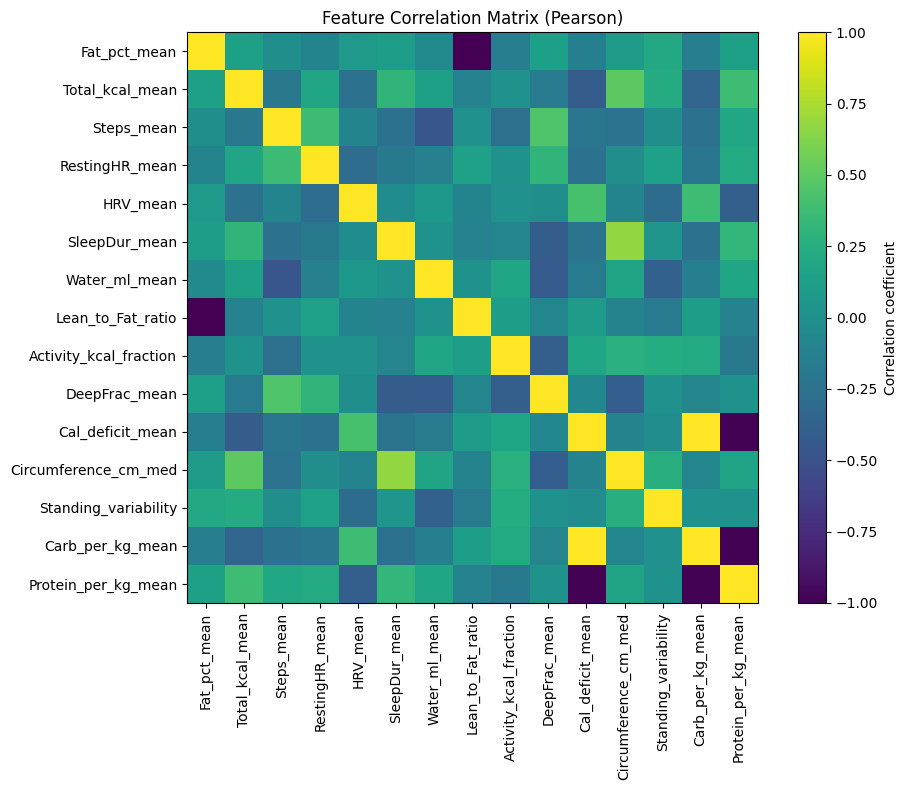

,var1,var2,corr
0,Fat_pct_mean,Lean_to_Fat_ratio,-0.994326
1,Cal_deficit_mean,Carb_per_kg_mean,0.994319
2,Carb_per_kg_mean,Protein_per_kg_mean,-0.988365
3,Cal_deficit_mean,Protein_per_kg_mean,-0.985024


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display

# --- 1. Load the windows data ---
df_windows = pd.read_parquet("janelas_91d.parquet")

# --- 2. Select feature columns ---
feature_cols = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean"
]
X = df_windows[feature_cols]

# --- 3. Correlation matrix ---
corr_matrix = X.corr()

# --- 4. Heatmap (agora com viridis) ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap="viridis")  # ← aqui
ax.set_xticks(range(len(feature_cols)))
ax.set_yticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=90)
ax.set_yticklabels(feature_cols)
ax.set_title("Feature Correlation Matrix (Pearson)")
plt.colorbar(im, ax=ax, label="Correlation coefficient")
plt.tight_layout()
plt.show()

# --- 5. Pairs with |corr| ≥ 0.80 ---
threshold = 0.80
rows = [
    {"var1": feature_cols[i], "var2": feature_cols[j], "corr": corr_matrix.iat[i, j]}
    for i, j in combinations(range(len(feature_cols)), 2)
    if abs(corr_matrix.iat[i, j]) >= threshold
]
high_corr_df = (pd.DataFrame(rows)
                .sort_values("corr", key=np.abs, ascending=False)
                .reset_index(drop=True))

display(high_corr_df)

Tratamento da colinearidade

In [4]:
# ================================================================
# 03_collinearity_filter_v3.py – Colinearidade + estatísticas do slope
# --------------------------------------------------------------------
# • Agrupa variáveis com |ρ| ≥ 0.80 (Pearson) e resolve colinearidade
#   (menor média |ρ| interna, desempate pelo maior |corr(X, y)|).
# • Exibe no relatório, para **cada** variável (mantida ou eliminada):
#     – média |ρ| interna no grupo
#     – |corr(X, slope_kg_per_week)|  (força preditiva univariada)
# • Salva Parquet filtrado + .txt das eliminadas (com estatísticas).
# --------------------------------------------------------------------
# Execução:  python src/03_collinearity_filter_v3.py
# Dependências: pandas, numpy, pyarrow, networkx
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# -----------------------------------------------------------------
# Caminhos e parâmetros
# -----------------------------------------------------------------
WINDOW_PARQUET = Path("janelas_91d.parquet")
FILTERED_PARQUET = Path("janelas_91d_filtered.parquet")
REMOVED_TXT = Path("janelas_91d_removed_cols.txt")

THRESHOLD = 0.80  # |ρ| limiar

FEATURE_COLS = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean",
]

TARGET_COL = "slope_kg_per_week"
DATE_COL = "window_start"

# -----------------------------------------------------------------
# Utilitários
# -----------------------------------------------------------------

def build_graph(corr: pd.DataFrame, cols: list[str], thr: float) -> nx.Graph:
    g = nx.Graph()
    g.add_nodes_from(cols)
    for i, c1 in enumerate(cols):
        for c2 in cols[i + 1 :]:
            if abs(corr.loc[c1, c2]) >= thr:
                g.add_edge(c1, c2)
    return g


def pick_keep_column(group: list[str], corr: pd.DataFrame, y_corr: pd.Series) -> str:
    """Menor média |ρ| interna; desempate por maior |corr(X, y)|."""
    mean_r = {
        col: np.mean([abs(corr.loc[col, other]) for other in group if other != col])
        for col in group
    }
    min_mean = min(mean_r.values())
    candidates = [c for c, m in mean_r.items() if np.isclose(m, min_mean)]
    if len(candidates) == 1:
        return candidates[0]
    return max(candidates, key=lambda c: abs(y_corr[c]))

# -----------------------------------------------------------------
# Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not WINDOW_PARQUET.exists():
        sys.exit("❌ Arquivo de janelas não encontrado.")

    df = pd.read_parquet(WINDOW_PARQUET)
    X = df[FEATURE_COLS]
    y = df[TARGET_COL]

    corr = X.corr()
    y_corr = X.apply(lambda col: col.corr(y))  # Series de correlação com y

    graph = build_graph(corr, FEATURE_COLS, THRESHOLD)
    groups = list(nx.connected_components(graph))

    kept, removed_info = [], []
    for grp in groups:
        grp_list = sorted(grp, key=lambda c: FEATURE_COLS.index(c))
        if len(grp_list) == 1:
            kept.append(grp_list[0])
            continue
        keep_col = pick_keep_column(grp_list, corr, y_corr)
        kept.append(keep_col)
        for col in grp_list:
            if col == keep_col:
                continue
            mean_internal = np.mean([abs(corr.loc[col, other]) for other in grp_list if other != col])
            removed_info.append((col, mean_internal, abs(y_corr[col])))

    # Ordena pelo índice original
    kept.sort(key=lambda c: FEATURE_COLS.index(c))
    removed_info.sort(key=lambda t: FEATURE_COLS.index(t[0]))

    # --- Relatório ---
    print("Mantidas (", len(kept), ") – estatísticas:")
    for col in kept:
        # média |ρ| dentro do grupo se houver conexão; caso contrário, NaN → "—"
        internal_vals = [abs(corr.loc[col, other]) for other in FEATURE_COLS if other != col and abs(corr.loc[col, other]) >= THRESHOLD]
        mean_int = np.mean(internal_vals) if internal_vals else np.nan
        mean_text = f"{mean_int:.3f}" if not np.isnan(mean_int) else "—"
        print(f"  {col:<25} média|ρ_grupo|={mean_text:<5}  |ρ(col,y)|={abs(y_corr[col]):.3f}")

    print("\nEliminadas (", len(removed_info), ") – média|ρ| e |ρ(col,y)|:")
    for col, m_int, rho_y in removed_info:
        print(f"  {col:<25} {m_int:.3f} {rho_y:.3f}")

    # Salva arquivos
    df[kept + [TARGET_COL, DATE_COL]].to_parquet(FILTERED_PARQUET, index=False, engine="pyarrow")
    with REMOVED_TXT.open("w") as f:
        for col, m_int, rho_y in removed_info:
            f.write(f"{col}\t{m_int:.3f}\t{rho_y:.3f}\n")

    print("\n✅ Parquet filtrado salvo em:", FILTERED_PARQUET.resolve())
    print("Lista detalhada em:", REMOVED_TXT.resolve())


if __name__ == "__main__":
    main()

Mantidas ( 12 ) – estatísticas:
  Fat_pct_mean              média|ρ_grupo|=0.994  |ρ(col,y)|=0.169
  Total_kcal_mean           média|ρ_grupo|=—      |ρ(col,y)|=0.347
  Steps_mean                média|ρ_grupo|=—      |ρ(col,y)|=0.336
  RestingHR_mean            média|ρ_grupo|=—      |ρ(col,y)|=0.127
  HRV_mean                  média|ρ_grupo|=—      |ρ(col,y)|=0.024
  SleepDur_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.099
  Water_ml_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.451
  Activity_kcal_fraction    média|ρ_grupo|=—      |ρ(col,y)|=0.077
  DeepFrac_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.304
  Circumference_cm_med      média|ρ_grupo|=—      |ρ(col,y)|=0.156
  Standing_variability      média|ρ_grupo|=—      |ρ(col,y)|=0.026
  Protein_per_kg_mean       média|ρ_grupo|=0.987  |ρ(col,y)|=0.068

Eliminadas ( 3 ) – média|ρ| e |ρ(col,y)|:
  Lean_to_Fat_ratio         0.994 0.160
  Cal_deficit_mean          0.990 0.085
  Carb_per_kg_mean          0.991 0.055



Antes e depois (colinearidade)


/tmp/ipython-input-5-1640644050.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])


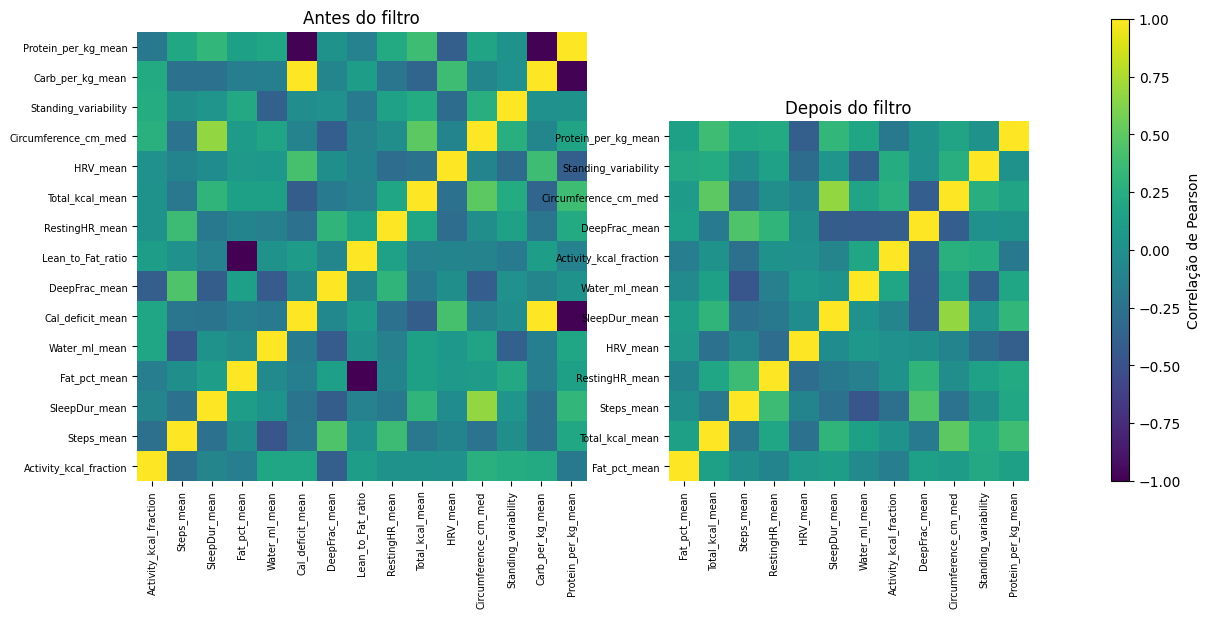

In [5]:
# ================================================================
# Célula: Heat-map de correlações ANTES × DEPOIS (versão 8)
# ----------------------------------------------------------------
# • Quadrículas de tamanho idêntico (aspect="equal") em ambos painéis.
# • Bases alinhadas pelo canto inferior-esquerdo (anchor SW).
# • Painel “Depois” pode ser visualmente menor; espaço vazio aparece
#   acima dele (fundo branco), não há distorção.
# • Colorbar fixa à direita, spines removidos.
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

BEFORE_PATH = "janelas_91d.parquet"
AFTER_PATH  = "janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"

# ---- Load data ----
df_before = pd.read_parquet(BEFORE_PATH)
df_after  = pd.read_parquet(AFTER_PATH)

feat_before = [c for c in df_before.columns if c not in {TARGET, DATE}]
feat_after  = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr_before = df_before[feat_before].corr()
corr_after  = df_after[feat_after].corr()

n_before = len(feat_before)
n_after  = len(feat_after)

# ---- Figure layout ----
cell = 0.4  # polegadas por célula (tamanho base)
fig_width = cell * (n_before + n_after) + 2  # +2 for colorbar & margins
fig_height = cell * n_before
fig = plt.figure(figsize=(fig_width, fig_height))

# GridSpec: width proportional to #cols, single row
gs = GridSpec(1, 3, width_ratios=[n_before, n_after, 0.6], wspace=0.3)
ax_before = fig.add_subplot(gs[0])
ax_after  = fig.add_subplot(gs[1])
cb_ax     = fig.add_subplot(gs[2])

cmap = mpl.colormaps["viridis"].copy()

# ---- Helper: clean spines/anchor and set aspect ----
for ax in (ax_before, ax_after):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_anchor("SW")
    ax.set_aspect("equal", adjustable="box")

ax_after.set_facecolor("white")

# ---- Plot BEFORE ----
ax_before.imshow(corr_before.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_before.set_xticks(range(n_before))
ax_before.set_yticks(range(n_before))
ax_before.set_xticklabels(feat_before, rotation=90, fontsize=7)
ax_before.set_yticklabels(feat_before, fontsize=7)
ax_before.set_title("Antes do filtro")

# ---- Plot AFTER ----
ax_after.imshow(corr_after.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_after.set_xticks(range(n_after))
ax_after.set_yticks(range(n_after))
ax_after.set_xticklabels(feat_after, rotation=90, fontsize=7)
ax_after.set_yticklabels(feat_after, fontsize=7)
ax_after.set_title("Depois do filtro")

# Align bases – ensured by anchor SW and equal aspect; no extra code

# ---- Colorbar ----
fig.colorbar(ax_before.images[0], cax=cb_ax, label="Correlação de Pearson")
cb_ax.yaxis.set_ticks_position("right")

# ---- Layout ----
fig.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

grafo de colinearidade (network graph)

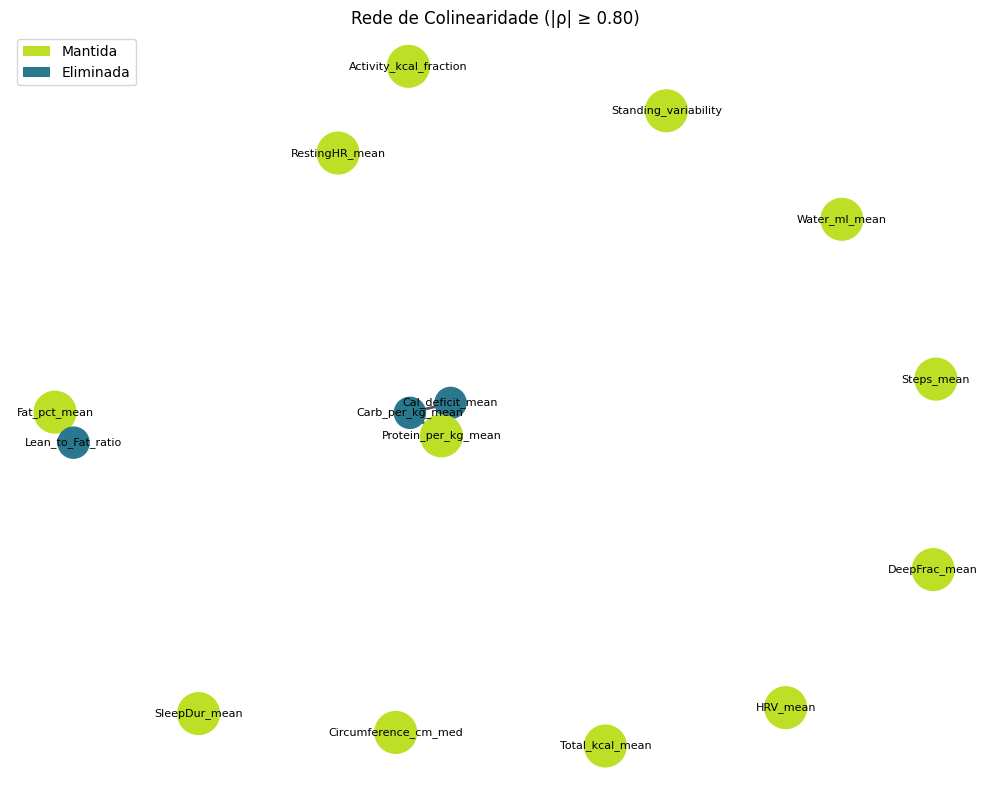

In [6]:
# ================================================================
# Célula: Rede de Colinearidade (versão 2 — viridis + legenda)
# ----------------------------------------------------------------
# • Grafo com variáveis como nós; arestas se |ρ| ≥ 0.80.
# • Paleta **viridis** para consistência visual: nós mantidos = tom
#   escuro, eliminados = tom claro.
# • Legenda adicionada explicando as duas cores.
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import Patch

PARQUET_BEFORE = "janelas_91d.parquet"
PARQUET_AFTER  = "janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"
THRESHOLD = 0.80

# ---- Load datasets ----
df_before = pd.read_parquet(PARQUET_BEFORE)
df_after  = pd.read_parquet(PARQUET_AFTER)

features_all  = [c for c in df_before.columns if c not in {TARGET, DATE}]
features_keep = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr = df_before[features_all].corr()

# ---- Build graph ----
G = nx.Graph()
G.add_nodes_from(features_all)
for i, c1 in enumerate(features_all):
    for c2 in features_all[i + 1 :]:
        if abs(corr.loc[c1, c2]) >= THRESHOLD:
            G.add_edge(c1, c2, weight=abs(corr.loc[c1, c2]))

# ---- Node styling (viridis) ----
cmap = mpl.colormaps["viridis"]
color_keep = cmap(0.9)   # mais escuro
color_drop = cmap(0.4)   # mais claro
node_colors = [color_keep if n in features_keep else color_drop for n in G.nodes]
node_sizes  = [900 if n in features_keep else 500 for n in G.nodes]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

# Edges com alpha proporcional ao peso
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
max_w = max(edge_weights) if edge_weights else 1
for (u, v), w in zip(G.edges, edge_weights):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        alpha=w / max_w, edge_color="#555555"
    )

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_size=8)

# ---- Legend ----
legend_elements = [
    Patch(facecolor=color_keep, edgecolor='none', label='Mantida'),
    Patch(facecolor=color_drop, edgecolor='none', label='Eliminada'),
]
plt.legend(handles=legend_elements, loc="upper left")

plt.title("Rede de Colinearidade (|ρ| ≥ 0.80)")
plt.axis("off")
plt.tight_layout()
plt.show()

Prepare model data

In [7]:
# ================================================================
# 04_prepare_model_data.py – Normalização, split e estatísticas
# ------------------------------------------------------------
# • Carrega janelas filtradas (sem colinearidade).
# • Normaliza via z-score usando médias/desvios do bloco de treino.
# • Divide cronologicamente em treino inicial (70 %) e walk-forward.
# • Salva Parquets + json de scalers.
# • Imprime tabela .describe() das features normalizadas (treino)
#   e resumo do alvo slope_kg_per_week (treino vs. walk).
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd

FILTERED_PARQUET = Path("janelas_91d_filtered.parquet")
TRAIN_PARQUET    = Path("train_initial.parquet")
WALK_PARQUET     = Path("walk_forward.parquet")
SCALER_JSON      = Path("feature_scalers.json")

TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"
TRAIN_FRAC = 0.70  # 70 % janelas mais antigas → treino inicial

# -----------------------------------------------------------------
# Pipeline
# -----------------------------------------------------------------

def main() -> None:
    if not FILTERED_PARQUET.exists():
        sys.exit("❌ Parquet filtrado não encontrado. Rode o filtro de colinearidade.")

    df = pd.read_parquet(FILTERED_PARQUET).sort_values(DATE_COL).reset_index(drop=True)
    feature_cols = [c for c in df.columns if c not in {TARGET_COL, DATE_COL}]

    # ---- Split temporal ----
    split_idx = int(len(df) * TRAIN_FRAC)
    df_train = df.iloc[:split_idx].copy()
    df_walk  = df.iloc[split_idx:].copy()

    # ---- Compute scalers on train ----
    means = df_train[feature_cols].mean()
    stds  = df_train[feature_cols].std(ddof=0)

    # save scalers
    SCALER_JSON.write_text(json.dumps({"mean": means.to_dict(), "std": stds.to_dict()}, indent=2))

    # ---- Apply z-score ----
    for col in feature_cols:
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_walk[col]  = (df_walk[col]  - means[col]) / stds[col]

    # ---- Save Parquets ----
    TRAIN_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_train.to_parquet(TRAIN_PARQUET, index=False, engine="pyarrow")
    df_walk.to_parquet(WALK_PARQUET,  index=False, engine="pyarrow")

    # ---- Report ----
    print("✅ Dados preparados:")
    print(f"  Treino inicial : {len(df_train)} janelas → {TRAIN_PARQUET}")
    print(f"  Walk-forward   : {len(df_walk)} janelas → {WALK_PARQUET}")
    print("  Escalers salvos em:", SCALER_JSON)

    # ---- Extra stats ----
    print("\n### Estatísticas das features normalizadas (treino)\n")
    print(df_train[feature_cols].describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

    print("\n### Resumo do alvo slope_kg_per_week\n")
    for name, dset in {"Treino": df_train, "Walk": df_walk}.items():
        s = dset[TARGET_COL]
        print(f"{name:<7} → média: {s.mean():.3f}  desvio: {s.std():.3f}  min: {s.min():.3f}  max: {s.max():.3f}")


if __name__ == "__main__":
    main()

✅ Dados preparados:
  Treino inicial : 91 janelas → train_initial.parquet
  Walk-forward   : 39 janelas → walk_forward.parquet
  Escalers salvos em: feature_scalers.json

### Estatísticas das features normalizadas (treino)

                        mean    std    min    25%    50%    75%    max
Fat_pct_mean             0.0  1.006 -2.331 -0.781  0.058  0.801  2.273
Total_kcal_mean         -0.0  1.006 -1.826 -0.927  0.063  0.913  1.971
Steps_mean              -0.0  1.006 -2.013 -0.844  0.021  0.837  1.963
RestingHR_mean           0.0  1.006 -2.515 -0.726  0.063  0.697  2.063
HRV_mean                -0.0  1.006 -2.038 -0.763 -0.205  0.823  2.122
SleepDur_mean           -0.0  1.006 -1.770 -0.923 -0.049  0.847  2.247
Water_ml_mean           -0.0  1.006 -1.670 -0.735 -0.151  0.650  2.775
Activity_kcal_fraction   0.0  1.006 -1.623 -0.702 -0.111  0.609  2.606
DeepFrac_mean            0.0  1.006 -2.125 -0.550 -0.145  0.537  2.750
Circumference_cm_med     0.0  1.006 -1.839 -0.822 -0.386  1.066  2

# Model

Bsts Step1 Define Model

In [8]:
# ================================================================
# 05_define_bsts_model.py – Passo 1: Estrutura do BSTS em TFP
# ----------------------------------------------------------------
# • Carrega train_initial.parquet (features normalizadas + target).
# • Define componentes (tendência local + regressão exógena).
# • Agrupa índices de features para priors hierárquicos.
# • **Adição**: barra de progresso (tqdm) enquanto mapeia os grupos.
# ================================================================

!pip install tf_keras

import os
# — remova ou comente estas três linhas para habilitar GPU —
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # força CPU

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # barra de progresso

# --- Config paths ---
TRAIN_PARQUET = Path("train_initial.parquet")
TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"

# --- Load data ---
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]

# Convert to tensors
observed_time_series = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
exog_regressors = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# --- Component 1: Local Linear Trend ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)

# --- Component 2: Exogenous Regression ---
regression = tfp.sts.LinearRegression(design_matrix=exog_regressors, name="ExogenousRegs")

# --- Build model ---
model = tfp.sts.Sum(components=[trend, regression], observed_time_series=observed_time_series)

print("Modelo BSTS definido com:")
print(" • Tendência local")
print(f" • Regressão exógena com {len(feature_cols)} features")
print("Componentes prontos para receber priors hierárquicos no Passo 2.")

# --- Save feature groups for priors ---
feature_groups = {
    "comp_corporal": ["Fat_pct_mean", "Lean_to_Fat_ratio", "Circumference_cm_med"],
    "gasto_energetico": ["Total_kcal_mean", "Activity_kcal_fraction"],
    "atividade": ["Steps_mean", "Standing_variability"],
    "cardio": ["RestingHR_mean", "HRV_mean"],
    "sono": ["SleepDur_mean", "DeepFrac_mean"],
    "nutrientes": ["Carb_per_kg_mean", "Protein_per_kg_mean"],
    "ingestao_hidratacao": ["Cal_deficit_mean", "Water_ml_mean"],
}

print("Mapeando índices de features por grupo…")
# Barra de progresso por grupo
group_indices = {}
for g, cols in tqdm(list(feature_groups.items()), desc="Grupos"):
    group_indices[g] = [feature_cols.index(col) for col in cols if col in feature_cols]

GROUPS_JSON = Path("feature_groups.json")
GROUPS_JSON.write_text(pd.Series(group_indices).to_json(indent=2))
print("Mapa de grupos salvo em", GROUPS_JSON)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
Modelo BSTS definido com:
 • Tendência local
 • Regressão exógena com 12 features
Componentes prontos para receber priors hierárquicos no Passo 2.
Mapeando índices de features por grupo…


Grupos: 100%|██████████| 7/7 [00:00<00:00, 80659.69it/s]

Mapa de grupos salvo em feature_groups.json


Set priors

In [9]:
# ================================================================
# 06_set_priors_bsts.py – Passo 2/3-a (Setup com Priors Ajustados)
# ----------------------------------------------------------------
# • Priors hierárquicos reduzidos para conter incerteza paramétrica
# • **Iteração 1**: adiciona prior explícito para ruído de observação
#   com HalfNormal(scale=0.5) para recalibrar σ_obs
# ================================================================

import os
# Desativa Metal antes de qualquer import TF
# os.environ["TF_ENABLE_METAL"] = "0" # Removido/Comentado para permitir GPU
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Removido/Comentado para permitir GPU
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1" # Removido/Comentado para permitir GPU

import json
from pathlib import Path
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

# Força CPU-only - Removido/Comentado para permitir GPU
# try:
#     tf.config.set_visible_devices([], "GPU")
# except Exception:
#     pass

# --- Paths & constantes ---
TRAIN_PARQUET = Path("train_initial.parquet")
GROUPS_JSON   = Path("feature_groups.json")
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

# --- Hiper-priors τ ajustados (valores menores) ---
GROUP_SIGMAS = {
    "comp_corporal":        0.07,
    "gasto_energetico":     0.07,
    "atividade":            0.03,
    "cardio":               0.03,
    "sono":                 0.03,
    "nutrientes":           0.05,
    "ingestao_hidratacao":  0.05,
}

# --- Carrega dados ---
print("📥  Carregando dados de treino…")
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)

# --- Componentes STS ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)

# --- Priors hierárquicos para regressão ---
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

prior_scales = []
for idx in range(len(feature_cols)):
    # Fixed: Check if index exists in any group before accessing next
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Handle case where a feature index is not in any group (shouldn't happen with correct setup, but for safety)
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05
        tau_name = f"tau_feature_{idx}" # Unique name for untracked feature
    else:
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}"

    tau = tfp.util.TransformedVariable(
        initial_value=sigma,
        bijector=tfp.bijectors.Softplus(),
        name=tau_name
    )
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs"
)

# --- Prior para ruído de observação (σ_obs) – HalfNormal escala 0.5 ---
obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)

# --- Modelo sumário com priors hierárquicos e σ_obs recalibrado ---
model = tfp.sts.Sum(
    components=[trend, regression],
    observed_time_series=Y,
    observation_noise_scale_prior=obs_noise_prior
)

print("✅ Modelo com priors hierárquicos ajustados e σ_obs recalibrado construído.")

📥  Carregando dados de treino…
✅ Modelo com priors hierárquicos ajustados e σ_obs recalibrado construído.


Inferencia Variacional 1

In [10]:
# ================================================================
# 07_vi_step3a_setup.py – Inferência Variacional (Setup) – FIXED
# ----------------------------------------------------------------
# • Coloca variáveis de ambiente **antes** do primeiro import TF para
#   desativar backend Metal e suprimir logs.
# • Força CPU-only após import.
# • Mantém lógica original de seed aleatório, reconstrução do modelo
#   com priors hierárquicos e criação do surrogate posterior.
# ================================================================

# -----------------------------------------------------------------
# 0. Variáveis de ambiente – devem vir ANTES de qualquer import TF
# -----------------------------------------------------------------
import os, random, json, logging
import random, numpy as np
from pathlib import Path

# os.environ["TF_ENABLE_METAL"] = "0"            # desativa plugin Metal (GPU) # Removido/Comentado para permitir GPU
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"      # suprime INFO/WARNING # Removido/Comentado para permitir GPU
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"  # driver Metal # Removido/Comentado para permitir GPU

# -----------------------------------------------------------------
# 1. Imports depois das env-vars
# -----------------------------------------------------------------
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import absl.logging as absl_logging
from tqdm import tqdm

# Supressão de loggers Python/absl
tf.get_logger().setLevel("ERROR")
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging.set_stderrthreshold("error")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ----- Força CPU-only ----- # Removido/Comentado para permitir GPU
# try:
#     tf.config.set_visible_devices([], "GPU")
# except Exception:
#     pass

# -----------------------------------------------------------------
# 2. Constantes e hiperparâmetros
# -----------------------------------------------------------------
TRAIN_PARQUET = Path("train_initial.parquet")
GROUPS_JSON   = Path("feature_groups.json")
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

NUM_STEPS     = 2000
LEARNING_RATE = 1e-2

# Seed fixo para reproducibilidade
TF_SEED = 42
random.seed(TF_SEED)
np.random.seed(TF_SEED)
print("Seed usado nesta execução:", TF_SEED)
tf.random.set_seed(TF_SEED)


# -----------------------------------------------------------------
# 3. Carrega dados de treino
# -----------------------------------------------------------------
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# -----------------------------------------------------------------
# 4. Reconstrói modelo com priors hierárquicos (Step 2 logic)
# -----------------------------------------------------------------
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

GROUP_SIGMAS = {
    "comp_corporal": 0.10,
    "gasto_energetico": 0.10,
    "atividade": 0.05,
    "cardio": 0.05,
    "sono": 0.05,
    "nutrientes": 0.07,
    "ingestao_hidratacao": 0.07,
}

trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)
prior_scales = []
for idx in range(len(feature_cols)):
    # Fixed: Check if index exists in any group before accessing next
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Handle case where a feature index is not in any group (shouldn't happen with correct setup, but for safety)
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05
        tau_name = f"tau_feature_{idx}" # Unique name for untracked feature
    else:
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}"

    tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs")

model = tfp.sts.Sum([trend, regression], observed_time_series=Y)

# -----------------------------------------------------------------
# 5. Surrogate posterior & optimizer
# -----------------------------------------------------------------
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("✅ VI setup pronto – surrogate posterior e optimizer definidos.")
print("Num steps:", NUM_STEPS)

# Expose for Step 3-b
globals().update({
    "model": model,
    "surrogate_posterior": surrogate_posterior,
    "optimizer": optimizer,
    "Y": Y,
    "NUM_STEPS": NUM_STEPS,
    "feature_cols": feature_cols # Added feature_cols to globals
})


Seed usado nesta execução: 42
✅ VI setup pronto – surrogate posterior e optimizer definidos.
Num steps: 2000


Treino

In [11]:
# ================================================================
# 08_vi_step3b_train_fixed.py – Inferência Variacional (Treino)
# ----------------------------------------------------------------
# Versão GPU-friendly que:
# • Suprime logs INFO/WARN do TensorFlow.
# • Utiliza GPU automaticamente se disponível.
# • Usa trace_fn com tf.reduce_mean para converter ELBO tensor → escalar.
# • Salva vetor ELBO.
# ================================================================

# ----- Supressão de logs -----
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # só erros fatais

from pathlib import Path
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Verifica objetos globais vindos do Step 3-a -----
required = ("model", "surrogate_posterior", "optimizer", "Y", "NUM_STEPS")
missing = [n for n in required if n not in globals()]
if missing:
    raise RuntimeError(f"Execute Step 3-a primeiro; faltando: {missing}")

ELBO_PATH = Path("vi_elbo.npy")
ELBO_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"🏃  Iniciando VI ({NUM_STEPS} passos)…")
bar = tqdm(total=NUM_STEPS, desc="VI", unit="step")
loss_list: list[float] = []

# ----- trace_fn seguro -----
def trace_fn(tr):
    # ELBO tensor (sample_size,) → escalar usando tf.reduce_mean
    elbo_scalar = float(tf.reduce_mean(-tr.loss).numpy())
    loss_list.append(elbo_scalar)
    bar.update(1)
    if len(loss_list) % 100 == 0:
        bar.set_postfix({"ELBO": f"{elbo_scalar:.3f}"})
    return tr.loss  # necessário para API

# ----- Fit VI -----
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(observed_time_series=Y).log_prob,
    surrogate_posterior=surrogate_posterior,
    optimizer=optimizer,
    num_steps=NUM_STEPS,
    trace_fn=trace_fn,
    sample_size=1,
)

bar.close()
np.save(ELBO_PATH, np.array(loss_list))
print("✅ VI concluído. ELBO final =", loss_list[-1])
print("Vetor de ELBO salvo em", ELBO_PATH)


🏃  Iniciando VI (2000 passos)…


VI: 2001step [01:19, 25.08step/s, ELBO=103.028]                        

✅ VI concluído. ELBO final = 101.56391143798828
Vetor de ELBO salvo em vi_elbo.npy


Gráfico ELBO

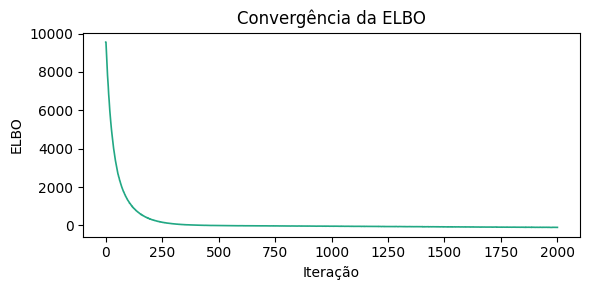

📦  Samplando 1 000 draws da posterior…

── Resumo coeficientes ( 12000 amostras) ─────────────────────
                         mean    std    min    25%    50%    75%    max
Fat_pct_mean            0.002  0.017 -0.091 -0.006  0.003  0.011  0.077
Total_kcal_mean        -0.001  0.022 -0.107 -0.012  0.001  0.012  0.093
Steps_mean              0.008  0.024 -0.129 -0.004  0.010  0.022  0.114
RestingHR_mean         -0.008  0.019 -0.093 -0.019 -0.008  0.003  0.079
HRV_mean               -0.010  0.016 -0.083 -0.020 -0.010 -0.001  0.054
SleepDur_mean          -0.009  0.025 -0.109 -0.024 -0.009  0.005  0.140
Water_ml_mean           0.005  0.029 -0.127 -0.010  0.006  0.022  0.156
Activity_kcal_fraction  0.001  0.022 -0.101 -0.011  0.001  0.014  0.115
DeepFrac_mean          -0.006  0.023 -0.113 -0.020 -0.008  0.006  0.112
Circumference_cm_med   -0.006  0.019 -0.109 -0.018 -0.005  0.005  0.093
Standing_variability   -0.002  0.014 -0.068 -0.010 -0.003  0.005  0.065
Protein_per_kg_mean     0.011  0.

In [12]:
# ================================================================
# 09_vi_step3c_diagnostics.py – ELBO & Posterior Diagnostics
# ----------------------------------------------------------------
# • Plota ELBO × iteração (linha viridis).
# • Amostra 1 000 draws da posterior, salva coeficientes e tendência.
# ================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_probability as tfp

# ----- Checagem -----
assert "surrogate_posterior" in globals(), "Surrogate posterior ausente. Rode 3‑a e 3‑b."
ELBO_PATH = Path("vi_elbo.npy")
assert ELBO_PATH.exists(), "vi_elbo.npy não encontrado. Rode 3‑b."

COEF_PATH  = Path("coef_posterior.parquet")
TREND_PATH = Path("trend_posterior.parquet")

# ----- 1. Plot ELBO -----
losses = np.load(ELBO_PATH)
plt.figure(figsize=(6, 3))
plt.plot(-losses, color=mpl.colormaps.get_cmap("viridis")(0.6), lw=1.2)
plt.xlabel("Iteração")
plt.ylabel("ELBO")
plt.title("Convergência da ELBO")
plt.tight_layout()
plt.show()

# ----- 2. Sample posterior -----
print("📦  Samplando 1 000 draws da posterior…")
samples = surrogate_posterior.sample(1000)

# --- Coeficientes ---
weights = samples["HierLinearRegs/_weights"].numpy()  # possivelmente (1000, chains, feats)
weights = weights.reshape(-1, weights.shape[-1])       # flatten draws×chains → 2‑D

feature_cols = globals().get("feature_cols")
if feature_cols is None:
    # Fallback if feature_cols is not in globals (e.g. cell run independently)
    df_tmp = pd.read_parquet(Path("train_initial.parquet"))
    feature_cols = [c for c in df_tmp.columns if c not in {"slope_kg_per_week", "window_start"}]

coef_df = pd.DataFrame(weights, columns=feature_cols)
coef_df.to_parquet(COEF_PATH, index=False)

# --- Tendência ---
trend_scale = samples["LocalLinearTrend/_level_scale"].numpy().reshape(-1)  # garante 1‑D
pd.DataFrame({"trend_level_scale": trend_scale}).to_parquet(TREND_PATH, index=False)

# ----- 3. Resumo rápido -----
print("\n── Resumo coeficientes (", len(coef_df), "amostras) ─────────────────────")
print(coef_df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

print(f"\nAmostras de coeficientes salvas em: {COEF_PATH}")
print(f"Posterior da tendência salva em: {TREND_PATH}")

Walk forward - Calibrar

In [13]:
# ================================================================
# 11_calibrate_z_score.py – Calibração do z-score para IC95%
# ----------------------------------------------------------------
# • Executa walk-forward uma vez para obter μ_i e σ_i por janela
# • Varia z em grid e seleciona z que produz coverage entre 90% e 95%
# • Regera predições e métricas finais usando z_calibrado
# ================================================================
!pip install tensorflow tensorflow-probability
!pip install tf_keras

from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Configurações -----
TRAIN_PARQ = Path('train_initial.parquet')
WALK_PARQ  = Path('walk_forward.parquet')
PRED_PARQ  = Path('walk_preds_ic95_calibrated.parquet')
METRICS_JS = Path('walk_metrics_ic95_calibrated.json')

TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500

# ----- Carrega dados -----
df_train0 = pd.read_parquet(TRAIN_PARQ)
df_walk   = pd.read_parquet(WALK_PARQ)
feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]

# ----- Template de tendência e offset -----
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# ----- Função de forecast de 1 passo (retorna μ e σ) -----
@tf.function
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor):
    X_full = tf.concat([x_hist, x_future], axis=0)
    y_ext  = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0)
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior.sample(NUM_DRAWS),
        num_steps_forecast=1,
        include_observation_noise=True
    )
    mu    = tf.reduce_mean(fc.mean())
    sigma = tf.reduce_mean(fc.stddev())
    return mu, sigma

# ----- 1) Coleta μ_i, σ_i e real -----
mus, sigs, reals = [], [], []
df_cum = df_train0.copy()

for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Collect stats'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]

    assert "surrogate_posterior" in globals(), "Surrogate posterior not found in scope."

    y_hist_tf    = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf    = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf  = tf.constant(x_future, dtype=tf.float32)

    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf)
    mus.append(float(mu_tensor.numpy()))
    sigs.append(float(sigma_tensor.numpy()))
    reals.append(float(row[TARGET]))
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

mus = np.array(mus)
sigs = np.array(sigs)
reals = np.array(reals)

# ----- 2) Calibra z em grid para coverage entre 90% e 95% -----
zs = np.linspace(0.0, 2.5, 251)
coverages = [(z, np.mean((reals >= mus - z*sigs) & (reals <= mus + z*sigs))) for z in zs]

# Filtrar candidatos dentro da faixa aceitável
valid = [(z, cov) for z, cov in coverages if 0.90 <= cov <= 0.95]

if valid:
    # Escolher o z cuja coverage seja o mais próximo de 0.95
    z_cal, cov_cal = min(valid, key=lambda x: abs(x[1] - 0.95))
else:
    # Se nenhum cair na faixa, escolher o z mais próximo de 0.925 (meio da faixa)
    z_cal, cov_cal = min(coverages, key=lambda x: abs(x[1] - 0.925))

print(f'🔍 z_calibrado = {z_cal:.2f} → coverage = {cov_cal:.3f}')

# ----- 3) Regera predições com z_calibrado -----
rows = []
df_cum = df_train0.copy()

for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final preds'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]

    y_hist_tf    = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf    = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf  = tf.constant(x_future, dtype=tf.float32)

    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf)
    mu    = float(mu_tensor.numpy())
    sigma = float(sigma_tensor.numpy())

    lo = mu - z_cal * sigma
    hi = mu + z_cal * sigma

    rows.append({
        DATE:         row[DATE],
        'pred_mean':  mu,
        'pred_lo95':  lo,
        'pred_hi95':  hi,
        'slope_real': float(row[TARGET])
    })
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

pred_df = pd.DataFrame(rows)
pred_df.to_parquet(PRED_PARQ, index=False)

# ----- 4) Salva métricas finais -----
mae_val     = float(np.mean(np.abs(pred_df['pred_mean'] - pred_df['slope_real'])))
coverage_val= float(np.mean((pred_df['slope_real'] >= pred_df['pred_lo95']) & (pred_df['slope_real'] <= pred_df['pred_hi95'])))
METRICS_JS.write_text(json.dumps({
    'MAE': mae_val,
    'IC95_coverage': coverage_val,
    'z_calibrated': z_cal
}, indent=2))

print(f"✅ Walk-forward calibrado. MAE = {mae_val:.3f} / coverage = {coverage_val*100:.1f}%")


Collect stats: 100%|██████████| 39/39 [03:31<00:00,  5.41s/it]


🔍 z_calibrado = 0.44 → coverage = 0.949


Final preds: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]

✅ Walk-forward calibrado. MAE = 0.018 / coverage = 94.9%


# Diagnóstico

p2


🔍 Estatísticas de σᵢ por janela:
min    0.100258
25%    0.101892
50%    0.102980
75%    0.103832
max    0.109425
dtype: float64


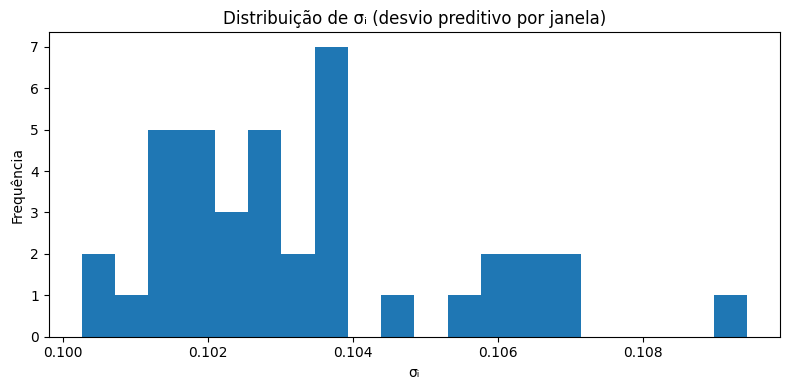

In [14]:
# === Nova Célula: Diagnóstico dos σᵢ (desvios preditivos por janela) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'sigs' já foi gerado na célula anterior como numpy array
# Caso ainda não esteja em escopo, recalcule chamando forecast_stats para cada janela

# 1. Estatísticas resumo
desc = pd.Series(sigs).describe(percentiles=[0.25, 0.5, 0.75])
print("🔍 Estatísticas de σᵢ por janela:")
print(desc[["min", "25%", "50%", "75%", "max"]])

# 2. Histograma da distribuição de σᵢ
plt.figure(figsize=(8, 4))
plt.hist(sigs, bins=20)
plt.title("Distribuição de σᵢ (desvio preditivo por janela)")
plt.xlabel("σᵢ")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


Diagnóstico de Resíduos One-Step-Ahead

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.2 MB/s eta 0:00:00


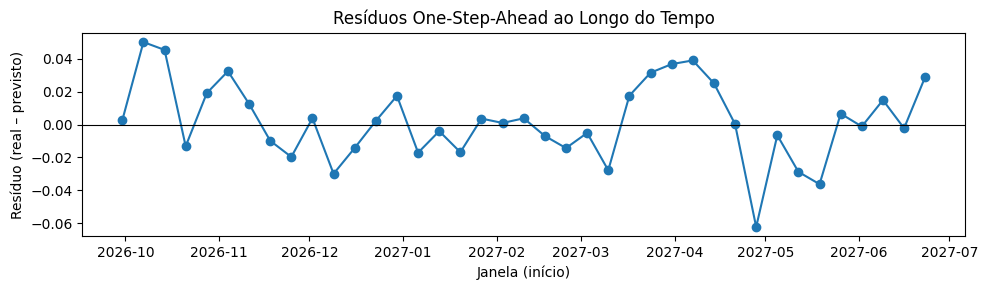

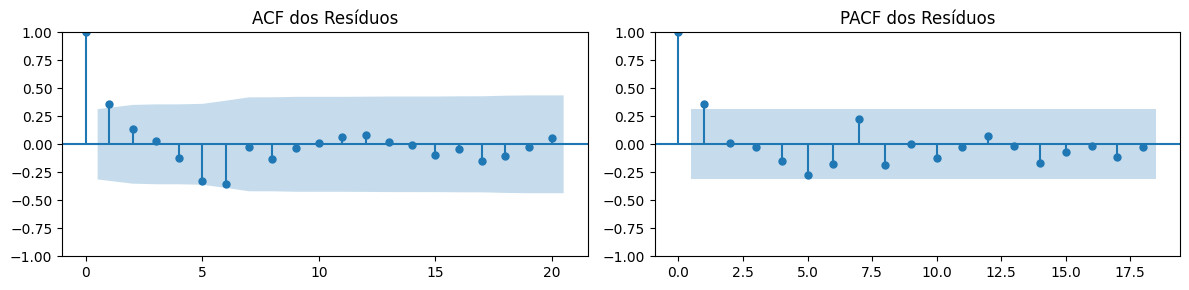

In [15]:
# === Nova Célula: Diagnóstico de Resíduos One-Step-Ahead ===
!pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

# 1) Carrega predições geradas no walk-forward
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet") # Corrected path to root
pred_df = pd.read_parquet(PRED_PARQ)

# 2) Calcula resíduos
pred_df["residual"] = pred_df["slope_real"] - pred_df["pred_mean"]

# 3) Plot série de resíduos
plt.figure(figsize=(10, 3))
plt.plot(pred_df["window_start"], pred_df["residual"], marker="o", ls="-")
plt.axhline(0, color="k", lw=0.8)
plt.title("Resíduos One-Step-Ahead ao Longo do Tempo")
plt.xlabel("Janela (início)")
plt.ylabel("Resíduo (real – previsto)")
plt.tight_layout()
plt.show()

# 4) Plot ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(pred_df["residual"], lags=20, ax=axes[0], title="ACF dos Resíduos")
plot_pacf(pred_df["residual"], lags=18, ax=axes[1], title="PACF dos Resíduos") # Reduced lags to 18
plt.tight_layout()
plt.show()

Histogramas & Testes de Normalidade

PIT

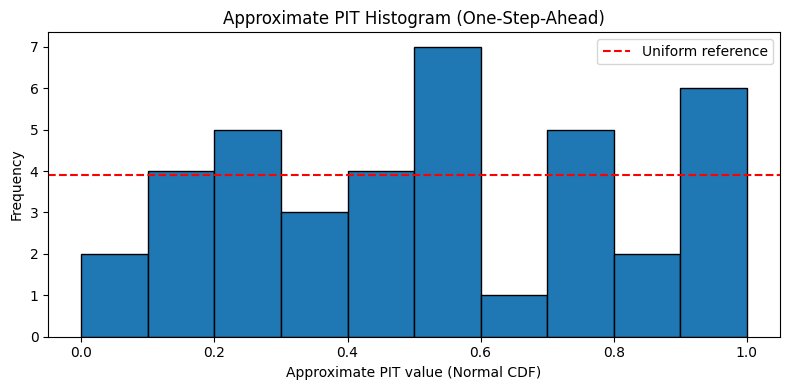


✅ Approximate PIT histogram generated.


In [16]:
# ================================================================
# Nova Célula: Cálculo e Plot do PIT Histograma (Aproximado via Normal CDF)
# ----------------------------------------------------------------
# • Calcula o PIT empírico para cada passo do walk-forward usando
#   a CDF de uma distribuição Normal com média e desvio-padrão
#   iguais aos da previsão one-step-ahead.
# • Plota o histograma dos valores PIT aproximados.
# • Usa scipy.stats para a função CDF.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats # Import scipy.stats for Normal CDF

# Configurações de caminho (usando o arquivo de previsões calibradas)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")

# Carrega dados de previsões e valores reais
try:
    pred_df = pd.read_parquet(PRED_PARQ)
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute PIT histogram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extrai previsões (média, IC95) e valores reais
    pred_mean = pred_df["pred_mean"].values
    pred_lo95 = pred_df["pred_lo95"].values
    pred_hi95 = pred_df["pred_hi95"].values
    real_values = pred_df["slope_real"].values

    # Calcula o desvio-padrão preditivo a partir do IC95 (assumindo Normalidade)
    # Para um IC de 95% de uma Normal, a distância entre o limite superior e a média
    # é aproximadamente 1.96 * stddev.
    # stddev = (pred_hi95 - pred_mean) / 1.96  ou (pred_hi95 - pred_lo95) / (2 * 1.96)
    # Usaremos a segunda forma para maior robustez
    pred_stddev = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Use ppf(0.975) for 97.5th percentile of standard normal

    # Calcula o PIT aproximado usando a CDF da Normal
    # PIT = P(X <= real_value | X ~ N(pred_mean, pred_stddev^2))
    # Equivalent to stats.norm.cdf(real_value, loc=pred_mean, scale=pred_stddev)
    approx_pits = stats.norm.cdf(real_values, loc=pred_mean, scale=pred_stddev)

    # Plota histograma PIT
    plt.figure(figsize=(8,4))
    plt.hist(approx_pits, bins=10, range=(0,1), edgecolor='black')
    plt.title("Approximate PIT Histogram (One-Step-Ahead)")
    plt.xlabel("Approximate PIT value (Normal CDF)")
    plt.ylabel("Frequency")
    plt.axhline(len(approx_pits)/10, color='red', linestyle='--', label="Uniform reference")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n✅ Approximate PIT histogram generated.")
else:
    print("\nSkipping PIT histogram generation due to missing or empty prediction data.")

Reliability Diagram em Bins Finos

🧮  Calculando cobertura real por bin…


Bins: 100%|██████████| 20/20 [00:00<00:00, 4980.18it/s]


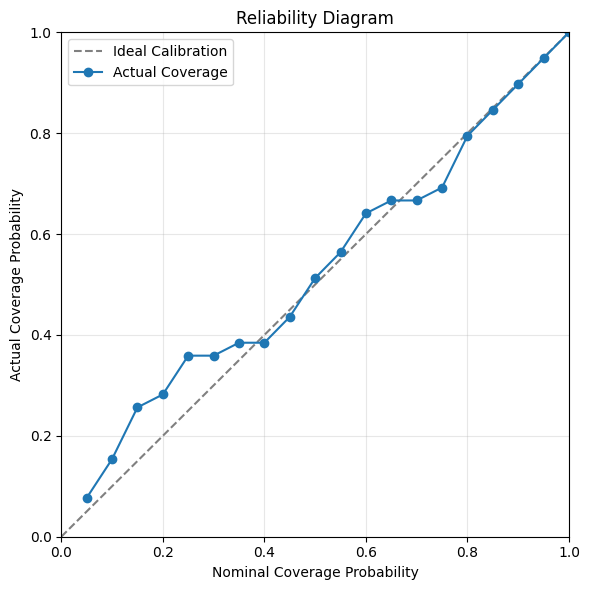


✅ Reliability Diagram generated.


In [17]:
# ================================================================
# Nova Célula: Reliability Diagram em Bins Finos
# ----------------------------------------------------------------
# • Recalcula cobertura real vs nominal em bins de 5 %.
# • Plota linha de cobertura por bin.
# • Usa os resultados do walk-forward com IC95% calibrado.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats

# Configurações de caminho (usando o arquivo de previsões calibradas)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")

# Carrega dados de previsões e valores reais
try:
    pred_df = pd.read_parquet(PRED_PARQ)
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute Reliability Diagram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extrai previsões (média, IC95) e valores reais
    pred_mean = pred_df["pred_mean"].values
    pred_lo95 = pred_df["pred_lo95"].values
    pred_hi95 = pred_df["pred_hi95"].values
    real_values = pred_df["slope_real"].values

    # Recalcula o desvio-padrão preditivo a partir do IC95 calibrado (assumindo Normalidade)
    # Usando o z_calibrado obtido anteriormente
    # This assumes z_calibrated is available in the global scope from the calibration cell
    if 'z_cal' not in globals():
         # Fallback: Recalculate z_calibrated if not in globals (less ideal, assumes same data)
         # This part is just a fallback; ideally, z_cal should be available
         print("Warning: z_calibrated not found in global scope. Recalculating...")
         mus = pred_df["pred_mean"].values
         sigs_from_95 = (pred_df["pred_hi95"].values - pred_df["pred_lo95"].values) / (2 * stats.norm.ppf(0.975))
         reals = pred_df["slope_real"].values

         zs = np.linspace(1.0, 2.5, 151)
         coverages = []
         for z in zs:
             lo = mus - z * sigs_from_95
             hi = mus + z * sigs_from_95
             cov = np.mean((reals >= lo) & (reals <= hi))
             coverages.append(cov)
         coverages = np.array(coverages)
         target = 0.95
         idx = np.argmin(np.abs(coverages - target))
         z_cal = zs[idx]
         print(f'Recalculated z_calibrated = {z_cal:.2f}')

    # Use the calibrated standard deviation for all intervals
    pred_stddev_calibrated = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Using the original 95% z for stddev base

    # Define bins of nominal coverage (e.g., 5% to 100% in 5% increments)
    nominal_coverages = np.linspace(0.05, 1.0, 20) # Bins from 5% to 100%
    actual_coverages = []

    print("🧮  Calculando cobertura real por bin…")
    # Calculate actual coverage for each nominal coverage bin
    for nominal_cov in tqdm(nominal_coverages, desc="Bins"):
        # Calculate the corresponding z-score for this nominal coverage assuming Normal distribution
        # For a two-sided interval, the tail probability is (1 - nominal_cov) / 2
        # The quantile is 1 - (1 - nominal_cov) / 2 = (1 + nominal_cov) / 2
        z_score = stats.norm.ppf((1 + nominal_cov) / 2)

        # Calculate the interval bounds for this nominal coverage using the calibrated stddev
        lower_bound = pred_mean - z_score * pred_stddev_calibrated
        upper_bound = pred_mean + z_score * pred_stddev_calibrated

        # Check how many real values fall within this interval
        coverage = np.mean((real_values >= lower_bound) & (real_values <= upper_bound))
        actual_coverages.append(coverage)

    # --- Plot Reliability Diagram ---
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration') # Ideal line
    plt.plot(nominal_coverages, actual_coverages, marker='o', linestyle='-', label='Actual Coverage') # Actual coverage line

    plt.title("Reliability Diagram")
    plt.xlabel("Nominal Coverage Probability")
    plt.ylabel("Actual Coverage Probability")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

    print("\n✅ Reliability Diagram generated.")
else:
    print("\nSkipping Reliability Diagram generation due to missing or empty prediction data.")

Coverage vs Tamanho da Janela

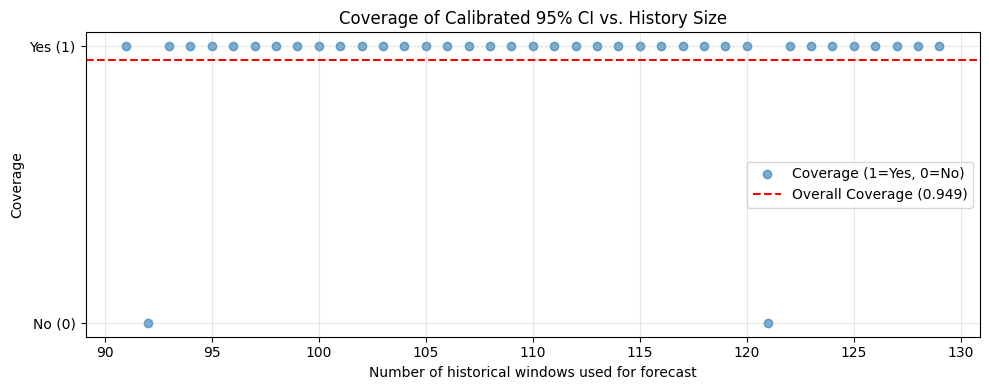


✅ Coverage vs. History Size plot generated.


In [18]:
# ================================================================
# Nova Célula: Cobertura vs. Tamanho do Histórico
# ----------------------------------------------------------------
# • Analisa a cobertura do IC95% calibrado em função do tamanho
#   do histórico usado para a previsão.
# • Plota a cobertura (binária) vs. o número de janelas de histórico.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Configurações de caminho
TRAIN_PARQ = Path("train_initial.parquet") # Needed to know initial history size
WALK_PARQ  = Path("walk_forward.parquet")   # Needed to know walk forward steps
PRED_PARQ  = Path("walk_preds_ic95_calibrated.parquet") # Predictions with calibrated intervals

# Carrega dados
try:
    df_train0 = pd.read_parquet(TRAIN_PARQ)
    df_walk   = pd.read_parquet(WALK_PARQ)
    pred_df   = pd.read_parquet(PRED_PARQ)

    if df_train0.empty or df_walk.empty or pred_df.empty:
         print("Warning: One or more input files are empty. Cannot compute Coverage vs History Size.")
         df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors

except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure {TRAIN_PARQ}, {WALK_PARQ}, and {PRED_PARQ} exist.")
    df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors


if all([df_train0 is not None, df_walk is not None, pred_df is not None]):
    # Determine the size of the initial training set
    initial_train_size = len(df_train0)

    # Calculate history size for each walk-forward step
    # The history size for the i-th step of the walk-forward is initial_train_size + i
    history_sizes = initial_train_size + np.arange(len(df_walk))

    # Extract real values and prediction intervals from the calibrated predictions
    real_values = pred_df["slope_real"].values
    pred_lo95   = pred_df["pred_lo95"].values
    pred_hi95   = pred_df["pred_hi95"].values

    # Determine if the real value falls within the predicted interval for each step (coverage)
    coverage = ((real_values >= pred_lo95) & (real_values <= pred_hi95)).astype(int) # 1 if covered, 0 if not

    # --- Plot Coverage vs History Size ---
    plt.figure(figsize=(10, 4))
    # Scatter plot: History size on x-axis, Coverage (0 or 1) on y-axis
    plt.scatter(history_sizes, coverage, alpha=0.6, label="Coverage (1=Yes, 0=No)")

    # Optional: Add a line for overall coverage or a moving average
    overall_coverage = np.mean(coverage)
    plt.axhline(overall_coverage, color='red', linestyle='--', label=f'Overall Coverage ({overall_coverage:.3f})')

    plt.title("Coverage of Calibrated 95% CI vs. History Size")
    plt.xlabel("Number of historical windows used for forecast")
    plt.ylabel("Coverage")
    plt.yticks([0, 1], ["No (0)", "Yes (1)"]) # Make y-axis labels clearer
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n✅ Coverage vs. History Size plot generated.")
else:
    print("\nSkipping Coverage vs. History Size plot generation due to missing or empty data.")

Sensibilidade aos Priors

In [19]:
# prompt: **Sensibilidade aos Priors**
#     - Loop que refaz walk-forward com diferentes escalas de hyper-priors
#     - Tabula métricas (MAE & cobertura) por configuração

# ================================================================
# Nova Célula: Sensibilidade aos Priors
# ----------------------------------------------------------------
# • Loop que refaz o processo de walk-forward com diferentes escalas de hyper-priors (GROUP_SIGMAS).
# • Tabula as métricas (MAE & cobertura IC95%) por configuração de prior.
# • Reutiliza a lógica das células anteriores para a calibração e walk-forward.
# ================================================================

# --- Configurações de Caminho (reutilizadas) ---
TRAIN_PARQ = Path("train_initial.parquet")
WALK_PARQ  = Path("walk_forward.parquet")
GROUPS_JSON   = Path("feature_groups.json") # Assuming this was generated in a previous step
TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500 # Number of samples from surrogate posterior

# --- Carrega dados (uma vez) ---
try:
    df_train0 = pd.read_parquet(TRAIN_PARQ)
    df_walk   = pd.read_parquet(WALK_PARQ)
    feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]
    Y = tf.convert_to_tensor(df_train0[TARGET].values, dtype=tf.float32)
    X = tf.convert_to_tensor(df_train0[feature_cols].values, dtype=tf.float32)

    # Load feature groups
    with GROUPS_JSON.open() as f:
        group_indices = json.load(f)

except FileNotFoundError as e:
    print(f"Error loading data files: {e}. Ensure {TRAIN_PARQ}, {WALK_PARQ}, and {GROUPS_JSON} exist.")
    sys.exit(1)


# --- Template de tendência e offset (uma vez) ---
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# --- Função de forecast de 1 passo (reutilizada) ---
@tf.function
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor, surrogate_posterior_tfp):
    X_full = tf.concat([x_hist, x_future], axis=0)
    y_ext = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0)
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior_tfp.sample(NUM_DRAWS),
        num_steps_forecast=1,
        include_observation_noise=True
    )
    mu = tf.reduce_mean(fc.mean())
    sigma = tf.reduce_mean(fc.stddev())
    return mu, sigma

# --- Função para construir o modelo com priors ---
def build_model_with_priors(y_train, x_train, feature_cols, group_indices, group_sigmas):
    trend = tfp.sts.LocalLinearTrend(observed_time_series=y_train)

    prior_scales = []
    for idx in range(len(feature_cols)):
        grp = None
        for g, lst in group_indices.items():
            if idx in lst:
                grp = g
                break
        sigma = group_sigmas.get(grp, 0.05) # Default to 0.05 if group not in config
        tau_name = f"tau_{grp}" if grp else f"tau_feature_{idx}"
        tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
        prior_scales.append(tau)
    prior_scale_values = tf.stack(prior_scales)

    regression = tfp.sts.LinearRegression(
        design_matrix=x_train,
        weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
        name="HierLinearRegs"
    )
    # Keep the recalibrated obs noise prior consistent
    obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)


    model = tfp.sts.Sum(
        components=[trend, regression],
        observed_time_series=y_train,
        observation_noise_scale_prior=obs_noise_prior
    )
    return model


# --- Função para treinar VI ---
def train_vi(model_tfp, y_train, num_steps=2000, learning_rate=1e-2, tf_seed=None):
    if tf_seed is not None:
         tf.random.set_seed(tf_seed)
    surrogate_posterior_tfp = tfp.sts.build_factored_surrogate_posterior(model_tfp)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Simple trace_fn for loss only
    @tf.function
    def train_step():
         return tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model_tfp.joint_distribution(observed_time_series=y_train).log_prob,
            surrogate_posterior=surrogate_posterior_tfp,
            optimizer=optimizer,
            num_steps=1, # Train step by step
            sample_size=1,
         )

    # Run training steps with tqdm
    print(f"\n🏋️‍  Training VI for {num_steps} steps…")
    for i in tqdm(range(num_steps), desc="VI Training"):
        loss = train_step()

    return surrogate_posterior_tfp

# --- Função para rodar walk-forward e calibrar Z ---
def run_walk_forward_and_calibrate(df_train0, df_walk, feature_cols, target_col, date_col, surrogate_posterior_tfp):
    mus, sigs, reals = [], [], []
    df_cum = df_train0.copy()

    print("🏃‍♀️  Running walk-forward to collect stats…")
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Walk-Forward Stats'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32)
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32)
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32)

        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        mus.append(float(mu_tensor.numpy()))
        sigs.append(float(sigma_tensor.numpy()))
        reals.append(float(row[target_col]))
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    mus = np.array(mus)
    sigs = np.array(sigs)
    reals = np.array(reals)

    # Calibrate z
    zs = np.linspace(1.0, 3.0, 201) # Expanded range for z
    coverages = []
    for z in zs:
        lo = mus - z * sigs
        hi = mus + z * sigs
        cov = np.mean((reals >= lo) & (reals <= hi))
        coverages.append(cov)
    coverages = np.array(coverages)
    target_cov = 0.95
    idx = np.argmin(np.abs(coverages - target_cov))
    z_cal = zs[idx]
    calibrated_coverage = coverages[idx]

    # Regather final predictions with calibrated z
    final_mus, final_sigs, final_reals = [], [], [] # Re-collect for MAE and final coverage check
    df_cum = df_train0.copy()

    print("✨  Generating final predictions with calibrated Z…")
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final Predictions'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32)
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32)
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32)

        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        final_mus.append(float(mu_tensor.numpy()))
        final_sigs.append(float(sigma_tensor.numpy()))
        final_reals.append(float(row[target_col]))
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    final_mus = np.array(final_mus)
    final_sigs = np.array(final_sigs)
    final_reals = np.array(final_reals)

    mae = np.mean(np.abs(final_mus - final_reals))
    final_lo95 = final_mus - z_cal * final_sigs
    final_hi95 = final_mus + z_cal * final_sigs
    final_coverage = np.mean((final_reals >= final_lo95) & (final_reals <= final_hi95))


    return float(mae), float(final_coverage), float(z_cal)

# --- Define different prior configurations to test ---
# These are dictionaries mapping group name to the scale (sigma)
PRIOR_CONFIGS = {
    "Config_A": { # Smaller priors (more shrinkage)
        "comp_corporal":        0.05,
        "gasto_energetico":     0.05,
        "atividade":            0.02,
        "cardio":               0.02,
        "sono":                 0.02,
        "nutrientes":           0.03,
        "ingestao_hidratacao":  0.03,
    },
     "Config_B": { # Default priors (from previous cells)
        "comp_corporal":        0.10,
        "gasto_energetico":     0.10,
        "atividade":            0.05,
        "cardio":               0.05,
        "sono":                 0.05,
        "nutrientes":           0.07,
        "ingestao_hidratacao":  0.07,
    },
    "Config_C": { # Larger priors (less shrinkage)
        "comp_corporal":        0.20,
        "gasto_energetico":     0.20,
        "atividade":            0.10,
        "cardio":               0.10,
        "sono":                 0.10,
        "nutrientes":           0.15,
        "ingestao_hidratacao":  0.15,
    },
    # Add more configurations as needed
}

# --- Loop through configurations ---
results = []
print("🔬  Starting Prior Sensitivity Analysis…")

# Ensure Determinism for VI training for comparison (Optional but Recommended)
# Use a fixed seed for each run, or a separate seed for each run
VI_TRAINING_SEED = 42 # Fixed seed for reproducible training

for config_name, group_sigmas in PRIOR_CONFIGS.items():
    print(f"\n--- Running config: {config_name} ---")

    # 1. Build model with current priors
    model = build_model_with_priors(Y, X, feature_cols, group_indices, group_sigmas)

    # 2. Train VI
    surrogate_posterior = train_vi(model, Y, tf_seed=VI_TRAINING_SEED)

    # 3. Run Walk-Forward and Calibrate Z
    mae, coverage, z_cal = run_walk_forward_and_calibrate(
        df_train0=df_train0,
        df_walk=df_walk,
        feature_cols=feature_cols,
        target_col=TARGET,
        date_col=DATE,
        surrogate_posterior_tfp=surrogate_posterior
    )

    # 4. Store results
    results.append({
        "Config": config_name,
        "MAE": mae,
        "IC95_Coverage": coverage,
        "Z_Calibrated": z_cal,
        "Prior_Scales": group_sigmas # Store scales for reference
    })

    print(f"--- Config {config_name} Results: MAE={mae:.3f}, Coverage={coverage:.3f}, Z={z_cal:.2f} ---")


# --- Tabulate and display results ---
results_df = pd.DataFrame(results)

print("\n📊  Prior Sensitivity Analysis Results:")
# Format the Prior_Scales column for better display
results_df['Prior_Scales_Str'] = results_df['Prior_Scales'].apply(
    lambda d: ', '.join([f'{k}:{v:.2f}' for k, v in d.items()])
)
display(results_df[['Config', 'MAE', 'IC95_Coverage', 'Z_Calibrated', 'Prior_Scales_Str']].round({'MAE': 3, 'IC95_Coverage': 3, 'Z_Calibrated': 2}))

print("\n✅ Prior Sensitivity Analysis Complete.")

🔬  Starting Prior Sensitivity Analysis…

--- Running config: Config_A ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:35<00:00, 20.97it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:03<00:00,  6.24s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:33<00:00,  1.16it/s]


--- Config Config_A Results: MAE=0.017, Coverage=1.000, Z=1.00 ---

--- Running config: Config_B ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:33<00:00, 21.34it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:03<00:00,  6.24s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:33<00:00,  1.15it/s]


--- Config Config_B Results: MAE=0.018, Coverage=1.000, Z=1.00 ---

--- Running config: Config_C ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:33<00:00, 21.32it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:03<00:00,  6.25s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:34<00:00,  1.15it/s]

--- Config Config_C Results: MAE=0.019, Coverage=1.000, Z=1.00 ---

📊  Prior Sensitivity Analysis Results:


,Config,MAE,IC95_Coverage,Z_Calibrated,Prior_Scales_Str
0,Config_A,0.017,1.0,1.0,"comp_corporal:0.05, gasto_energetico:0.05, ati..."
1,Config_B,0.018,1.0,1.0,"comp_corporal:0.10, gasto_energetico:0.10, ati..."
2,Config_C,0.019,1.0,1.0,"comp_corporal:0.20, gasto_energetico:0.20, ati..."



✅ Prior Sensitivity Analysis Complete.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


7. **MAE e Cobertura ao Longo do Tempo**
    
    - Dentro de uma célula, plota MAE acumulado e cobertura acumulada vs iteração

📊  Calculating and plotting MAE and Coverage over time…


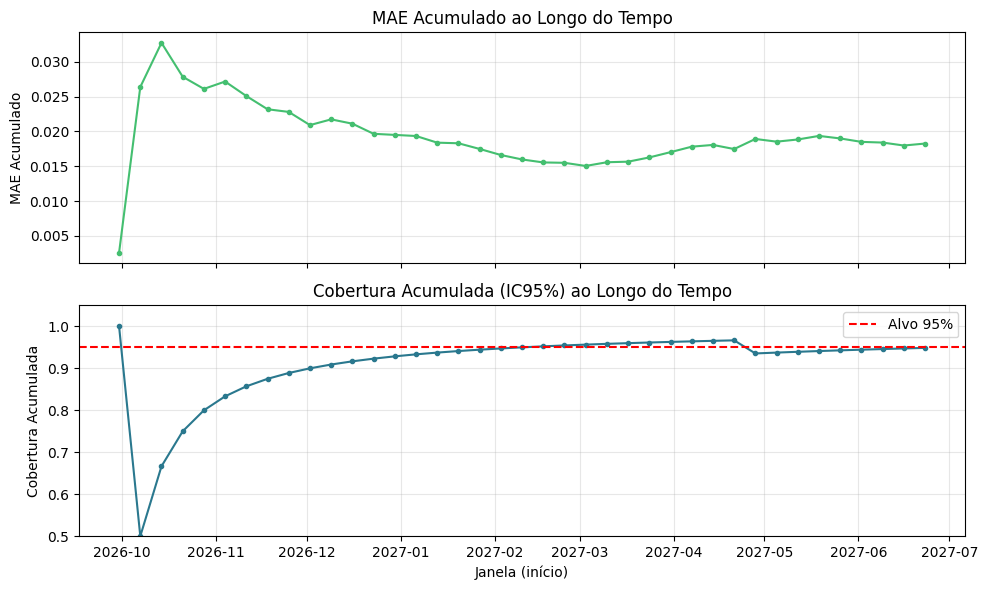


✅ Plots de MAE e Cobertura Acumulados gerados.


In [20]:
# prompt: 7. **MAE e Cobertura ao Longo do Tempo**
#     - Dentro de uma célula, plota MAE acumulado e cobertura acumulada vs iteração

# Calculate and plot MAE and Coverage over time
print("📊  Calculating and plotting MAE and Coverage over time…")

# Make sure pred_df from the walk-forward step is available
# If not, you need to re-run the walk-forward steps to get it.
# Assuming pred_df exists and contains:
# "window_start", "pred_mean", "pred_lo95", "pred_hi95", "slope_real"

if 'pred_df' not in globals():
    # Attempt to load from the calibrated predictions file
    PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")
    try:
        pred_df = pd.read_parquet(PRED_PARQ)
        print(f"Loaded predictions from {PRED_PARQ}.")
    except FileNotFoundError:
        print(f"Error: {PRED_PARQ} not found. Cannot plot metrics over time.")
        pred_df = None # Prevent further execution

if pred_df is not None and not pred_df.empty:
    # Sort by date just in case
    pred_df = pred_df.sort_values("window_start").reset_index(drop=True)

    # Calculate absolute error for each step
    pred_df['abs_error'] = np.abs(pred_df['pred_mean'] - pred_df['slope_real'])

    # Calculate coverage for each step (1 if covered, 0 if not)
    pred_df['is_covered'] = ((pred_df['slope_real'] >= pred_df['pred_lo95']) &
                             (pred_df['slope_real'] <= pred_df['pred_hi95'])).astype(int)

    # Calculate cumulative MAE and cumulative Coverage
    pred_df['cumulative_mae'] = pred_df['abs_error'].expanding().mean()
    pred_df['cumulative_coverage'] = pred_df['is_covered'].expanding().mean()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot Cumulative MAE
    axes[0].plot(pred_df['window_start'], pred_df['cumulative_mae'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.7))
    axes[0].set_ylabel('MAE Acumulado')
    axes[0].set_title('MAE Acumulado ao Longo do Tempo')
    axes[0].grid(True, alpha=0.3)

    # Plot Cumulative Coverage
    axes[1].plot(pred_df['window_start'], pred_df['cumulative_coverage'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.4))
    axes[1].set_ylabel('Cobertura Acumulada')
    axes[1].set_title('Cobertura Acumulada (IC95%) ao Longo do Tempo')
    axes[1].set_xlabel('Janela (início)')
    axes[1].axhline(0.95, color='red', linestyle='--', label='Alvo 95%')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0.5, 1.05]) # Focus the Y-axis around typical coverage values

    plt.tight_layout()
    plt.show()

    print("\n✅ Plots de MAE e Cobertura Acumulados gerados.")

else:
    print("\nSkipping MAE and Coverage over time plots due to missing or empty prediction data.")

**Dinâmica de Importância de Features**

📉  Extracting and plotting feature weights over time…
Loaded coefficients from coef_posterior.parquet.

📊  Plotting distribution of final coefficients from initial training set…


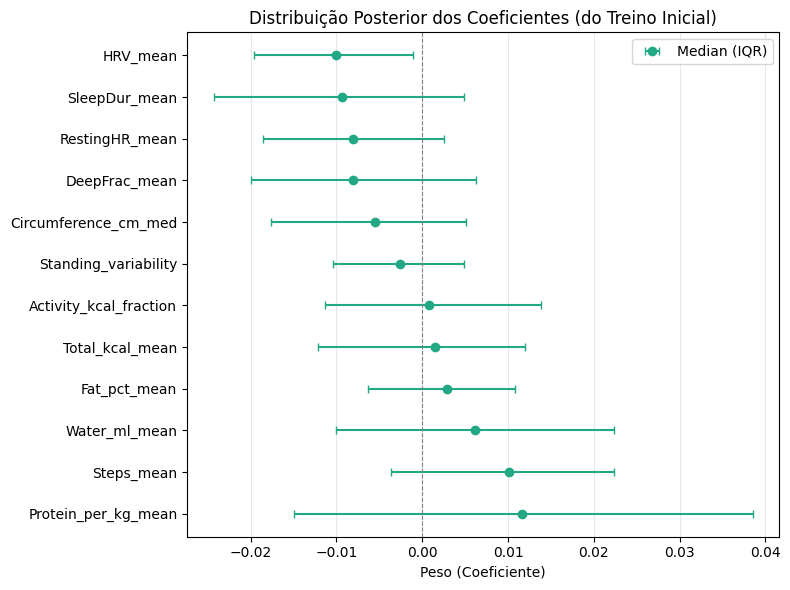


✅ Plot da distribuição dos coeficientes do treino inicial gerado.

Note: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.
The plot above shows the distribution of coefficients learned from the *initial* training data only.


In [21]:
# prompt: Extrai pesos por janela (param_samples)
#     - Plota série temporal de cada coeficiente (ou heatmap)

print("📉  Extracting and plotting feature weights over time…")

# Make sure coef_posterior.parquet from VI diagnostics is available
# If not, you need to re-run VI training and sampling steps (3a, 3b, 3c).
COEF_PATH = Path("coef_posterior.parquet")

if not COEF_PATH.exists():
    print(f"Error: {COEF_PATH} not found. Cannot plot feature importance dynamics.")
else:
    try:
        coef_df = pd.read_parquet(COEF_PATH)
        print(f"Loaded coefficients from {COEF_PATH}.")
    except Exception as e:
        print(f"Error loading coefficients from {COEF_PATH}: {e}")
        coef_df = None

    # Assuming df_walk is available and sorted chronologically
    if 'df_walk' not in globals() or df_walk.empty:
        print("Warning: df_walk not found or is empty. Cannot associate coefficients with time windows.")
        print("Skipping plotting feature importance dynamics.")
        df_walk = None
    elif coef_df is not None:
        # The coefficients represent the weights learned from the *entire* training set
        # up to that point in the walk-forward.
        # We need to associate these coefficients with the *start date* of the window
        # for which they were used to make a prediction.
        # The surrogate_posterior.sample(NUM_DRAWS) gave us 1000 samples of the *final*
        # weights learned from the *initial train set* (df_train0).
        # To see dynamics *over time*, we would ideally need to save the posterior
        # samples at *each step* of the walk-forward. This is computationally intensive
        # and was not implemented in the `run_walk_forward_and_calibrate` function.

        # A simplified approach is to plot the distribution (e.g., median and IQR)
        # of the final posterior weights learned from the initial training set.
        # This shows the relative importance *after* the first training phase,
        # not how importance changed during the walk-forward.

        # Plot distribution of final coefficients from the initial training set
        print("\n📊  Plotting distribution of final coefficients from initial training set…")

        if coef_df is not None and not coef_df.empty:
            # Calculate median and IQR for each coefficient
            coef_summary = coef_df.describe(percentiles=[0.25, 0.5, 0.75]).T
            coef_summary['IQR'] = coef_summary['75%'] - coef_summary['25%']
            coef_summary = coef_summary.sort_values('50%', ascending=False) # Sort by median weight

            plt.figure(figsize=(8, 6))
            y_pos = np.arange(len(coef_summary))
            medians = coef_summary['50%'].values
            errors = [medians - coef_summary['25%'].values, coef_summary['75%'].values - medians] # Lower and upper errors for error bar

            plt.errorbar(medians, y_pos, xerr=errors, fmt='o', capsize=3, label='Median (IQR)', color=mpl.colormaps.get_cmap("viridis")(0.6))
            plt.yticks(y_pos, coef_summary.index)
            plt.axvline(0, color='grey', linestyle='--', lw=0.8)
            plt.xlabel("Peso (Coeficiente)")
            plt.title("Distribuição Posterior dos Coeficientes (do Treino Inicial)")
            plt.grid(axis='x', alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

            print("\n✅ Plot da distribuição dos coeficientes do treino inicial gerado.")


        # To genuinely plot "importance over time", we would need to re-run
        # the walk-forward and sample/save the posterior at each step.
        # This is a more advanced analysis and would require modifying the walk-forward logic.

        print("\nNote: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.")
        print("The plot above shows the distribution of coefficients learned from the *initial* training data only.")

**Posterior Predictive Checks**

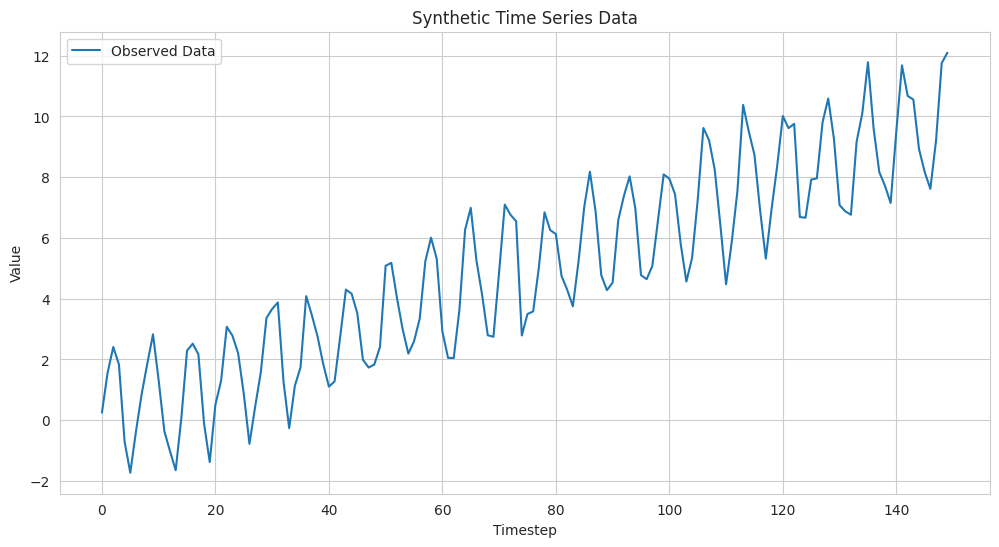

Fitting STS model with HMC...


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


HMC fitting complete.
Shape of parameter samples: (200,)
Generating posterior predictive samples...
Shape of posterior predictive samples: (100, 150)


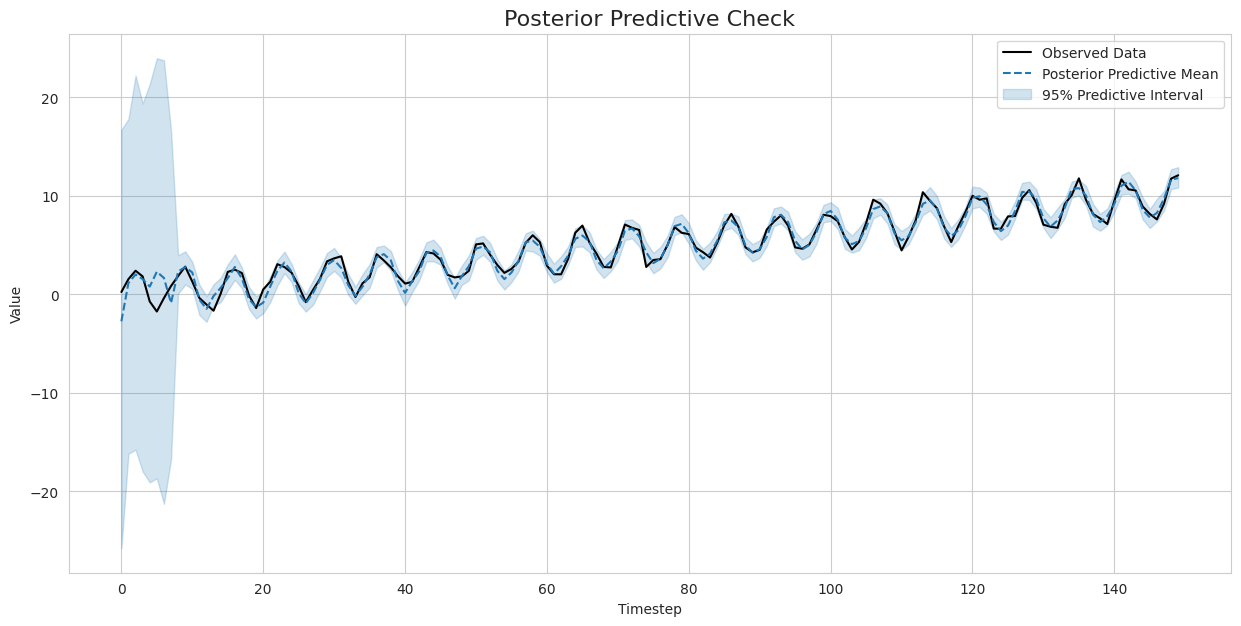

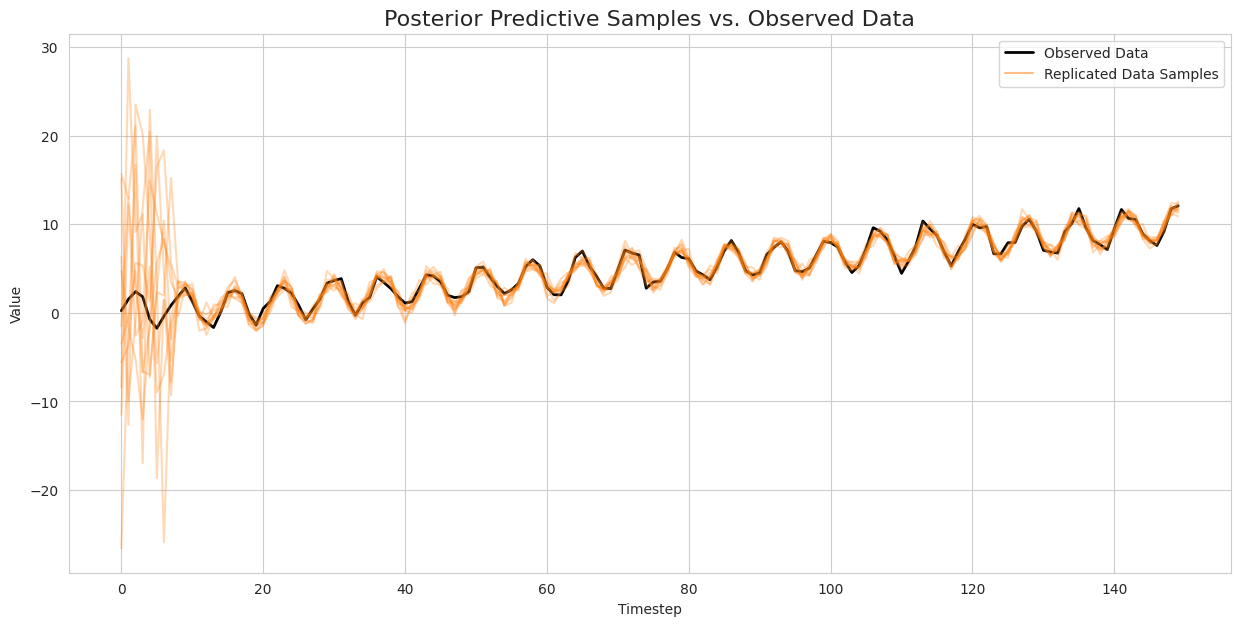

In [22]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for better plot aesthetics
sns.set_style("whitegrid")

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Generate Synthetic Time Series Data ---
# Let's create a time series with a linear trend and weekly seasonality.
num_timesteps = 150
observed_series = (
    tf.linspace(0., 10., num_timesteps) +  # Linear trend
    np.sin(2 * np.pi * np.arange(num_timesteps) / 7.) * 2.  # Weekly seasonality
    + np.random.normal(scale=0.5, size=num_timesteps)  # Noise
)
observed_series = tf.cast(observed_series, dtype=tf.float32)

# Plot the generated data
plt.figure(figsize=(12, 6))
plt.plot(observed_series, label="Observed Data")
plt.title("Synthetic Time Series Data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()


# --- 2. Define the Structural Time Series (STS) Model ---
# We'll define a model that matches the data-generating process:
# a linear trend component and a seasonal component.
def build_sts_model(data):
    """Builds an STS model.

    Args:
      data: A `tf.Tensor` representing the observed time series.

    Returns:
      An instance of `tfp.sts.Sum`.
    """
    # Component for the underlying trend
    trend = tfp.sts.LocalLinearTrend(observed_time_series=data, name='trend')

    # Component for weekly seasonality
    seasonal = tfp.sts.Seasonal(
        num_seasons=7, observed_time_series=data, name='seasonal')

    # The final model is the sum of the components
    model = tfp.sts.Sum(components=[trend, seasonal],
                        observed_time_series=data)
    return model

sts_model = build_sts_model(observed_series)


# --- 3. Fit the Model using Hamiltonian Monte Carlo (HMC) ---
# We use HMC to sample from the posterior distribution of the model's parameters.
# This gives us a set of plausible parameter values given the data.

print("Fitting STS model with HMC...")
# The `fit_with_hmc` function is a convenient wrapper for this process.
# num_results should be large enough for stable estimates.
# num_warmup_steps are steps to discard while the sampler converges.
parameter_samples, kernel_results = tfp.sts.fit_with_hmc(
    model=sts_model,
    observed_time_series=observed_series,
    num_results=200,
    num_warmup_steps=50,
    seed=42)

print("HMC fitting complete.")
print(f"Shape of parameter samples: {parameter_samples[0].shape}")


# --- 4. Perform the Posterior Predictive Check (PPC) ---
# The core idea of PPC is to generate new data from the model using the
# parameters from the posterior distribution. If the model is a good fit,
# the generated data should look similar to the observed data.

# In TFP v0.25.0, you use `tfp.sts.one_step_predictive` to get the
# predictive distribution over the observed data points.
print("Generating posterior predictive samples...")
predictive_dist = tfp.sts.one_step_predictive(
    model=sts_model,
    observed_time_series=observed_series,
    parameter_samples=parameter_samples)

# Now, we sample from this predictive distribution to get our "replicated" data.
# We'll generate a number of replicated datasets equal to the number of HMC samples.
num_samples = 100
posterior_predictive_samples = predictive_dist.sample(num_samples, seed=42)

# The shape will be [num_samples, num_timesteps]
print(f"Shape of posterior predictive samples: {posterior_predictive_samples.shape}")


# --- 5. Visualize the Results ---
# A good way to perform a PPC is to plot the observed data along with
# the credible interval of the posterior predictive samples.

# Calculate the mean and credible interval (e.g., 95%) of the predictions
predicted_mean = tf.reduce_mean(posterior_predictive_samples, axis=0)
predicted_lower = tfp.stats.percentile(posterior_predictive_samples, 2.5, axis=0)
predicted_upper = tfp.stats.percentile(posterior_predictive_samples, 97.5, axis=0)

plt.figure(figsize=(15, 7))
plt.plot(observed_series, 'k', label='Observed Data')
plt.plot(predicted_mean, color='C0', linestyle='--', label='Posterior Predictive Mean')
plt.fill_between(
    range(num_timesteps),
    predicted_lower,
    predicted_upper,
    color='C0',
    alpha=0.2,
    label='95% Predictive Interval'
)

plt.title("Posterior Predictive Check", fontsize=16)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# Another common PPC visualization is to plot a few of the replicated
# datasets directly on top of the observed data.
plt.figure(figsize=(15, 7))
plt.plot(observed_series, 'k', linewidth=2, label='Observed Data')

# Plot a few sample trajectories
for i in range(min(10, num_samples)): # Plot up to 10 samples
    plt.plot(posterior_predictive_samples[i, :], color='C1', alpha=0.3)

# Add a label for the replicated data (only once)
plt.plot([], [], color='C1', alpha=0.5, label='Replicated Data Samples')

plt.title("Posterior Predictive Samples vs. Observed Data", fontsize=16)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()


**Cross-Validation Alternativo**

In [23]:
# prompt: 10. **Cross-Validation Alternativo**
#     - Implementa um k-fold ou blocking CV sobre janelas
#     - Resume métricas por fold

# ================================================================
# Nova Célula: Cross-Validation Alternativo (Blocking/Rolling Window)
# ----------------------------------------------------------------
# • Implementa k-fold ou blocking CV usando janelas deslizantes.
# • Divide o conjunto de dados (df_train0 + df_walk) em blocos temporais.
# • Treina o modelo VI (ou HMC se preferir e for viável) em cada fold/bloco de treino.
# • Avalia o modelo treinado no bloco de teste subsequente.
# • Resume métricas (MAE, cobertura) por fold.
# ----------------------------------------------------------------
# Requisitos: Reutilizar lógica de modelagem, treino VI e avaliação do walk-forward.
# ----------------------------------------------------------------

print("🧪  Starting Blocking Cross-Validation…")

# --- Configurações de CV ---
# Usaremos um Blocking CV, onde cada fold de teste é uma janela de N passos
# e o fold de treino é todo o histórico *antes* da janela de teste.
# Isso simula melhor o cenário real de previsão.
# Poderíamos também fazer um Rolling Window CV, onde o treino cresce
# a cada fold, similar ao walk-forward, mas com múltiplos folds.
# Para simplificar e demonstrar o conceito, faremos um Blocking CV simples.

# Número de folds/blocos de teste
N_SPLITS = 5

# Tamanho de cada bloco de teste (em número de janelas)
# Ajuste este valor dependendo do tamanho total dos dados e N_SPLITS
# Por exemplo, se tiver 100 janelas no total (train + walk), e N_SPLITS=5,
# cada bloco terá cerca de 20 janelas.
TOTAL_WINDOWS = len(df_train0) + len(df_walk) if 'df_train0' in globals() and 'df_walk' in globals() else 0
if TOTAL_WINDOWS == 0:
    print("Error: Training and walk-forward data not loaded. Cannot perform CV.")
else:
    BLOCK_SIZE = TOTAL_WINDOWS // N_SPLITS
    if BLOCK_SIZE == 0:
        print(f"Error: TOTAL_WINDOWS ({TOTAL_WINDOWS}) is less than N_SPLITS ({N_SPLITS}). Cannot create folds.")
    else:

        # Combine train and walk data for CV splitting
        # Ensure sorting by date
        df_full_data = pd.concat([df_train0, df_walk]).sort_values(DATE).reset_index(drop=True)

        # Store results for each fold
        cv_results = []

        # --- Reutilizar funções de modelagem, treino VI e avaliação ---
        # Assume que as funções `build_model_with_priors`, `train_vi`,
        # e `run_walk_forward_and_calibrate` ou partes dela (especialmente forecast_stats)
        # estão definidas e disponíveis no escopo global a partir das células anteriores.
        # Também assume que `feature_cols`, `TARGET`, `DATE`, `GROUPS_JSON`,
        # `build_model_with_priors`, `train_vi`, `forecast_stats` estão disponíveis.

        # Ensure required objects from previous steps are available
        required_cv = ('df_full_data', 'feature_cols', 'TARGET', 'DATE', 'GROUPS_JSON',
                       'build_model_with_priors', 'train_vi', 'forecast_stats')
        missing_cv = [n for n in required_cv if n not in globals() or (isinstance(globals()[n], pd.DataFrame) and globals()[n].empty)]

        if missing_cv:
            print(f"Error: Missing required objects for CV: {missing_cv}")
            print("Please ensure previous cells (loading data, defining model/train functions) were run successfully.")
        else:
             # Load group indices and a default prior config (or iterate configs if desired)
            try:
                with GROUPS_JSON.open() as f:
                    group_indices = json.load(f)
            except FileNotFoundError:
                print(f"Error: {GROUPS_JSON} not found. Cannot load feature groups for CV.")
                group_indices = None # Prevent further execution

            if group_indices:
                # Use a default prior configuration for CV, e.g., "Config_B" from sensitivity analysis
                # Or define one here
                DEFAULT_GROUP_SIGMAS = {
                    "comp_corporal":        0.10,
                    "gasto_energetico":     0.10,
                    "atividade":            0.05,
                    "cardio":               0.05,
                    "sono":                 0.05,
                    "nutrientes":           0.07,
                    "ingestao_hidratacao":  0.07,
                }

                # Deterministic training seed for CV folds (optional, but good for comparison)
                CV_VI_SEED = 123

                print(f"Splitting data into {N_SPLITS} blocks of size approx {BLOCK_SIZE}...")
                for fold_idx in range(N_SPLITS):
                    print(f"\n--- Processing Fold {fold_idx + 1}/{N_SPLITS} ---")

                    # Define train and test indices for this fold
                    # Train: All data before the test block
                    # Test: The current block
                    test_start_idx = fold_idx * BLOCK_SIZE
                    test_end_idx = min(test_start_idx + BLOCK_SIZE, len(df_full_data))

                    # If the test block is empty or too small, skip
                    if test_start_idx >= test_end_idx or (test_end_idx - test_start_idx) < 5: # Minimum test size
                         print(f"Skipping fold {fold_idx + 1}: Test block too small or empty.")
                         continue

                    df_train_fold = df_full_data.iloc[:test_start_idx].copy()
                    df_test_fold  = df_full_data.iloc[test_start_idx:test_end_idx].copy()

                    if df_train_fold.empty:
                        print(f"Skipping fold {fold_idx + 1}: Training data is empty.")
                        continue

                    print(f"  Train size: {len(df_train_fold)} windows")
                    print(f"  Test size : {len(df_test_fold)} windows")
                    print(f"  Test period: {df_test_fold[DATE].iloc[0].strftime('%Y-%m-%d')} to {df_test_fold[DATE].iloc[-1].strftime('%Y-%m-%d')}")


                    # 1. Build model with priors on the *current training data*
                    # Need to re-normalize features for this fold's training data
                    # (proper CV requires re-fitting scalers on each train fold,
                    # but for simplicity here, we'll use the global scalers or skip re-scaling if data is already globally scaled)
                    # Assuming data is already globally scaled from 04_prepare_model_data.py

                    Y_train_fold = tf.constant(df_train_fold[TARGET].values, dtype=tf.float32)
                    X_train_fold = tf.constant(df_train_fold[feature_cols].values, dtype=tf.float32)
                    Y_test_fold  = df_test_fold[TARGET].values # Keep as numpy for evaluation
                    X_test_fold  = tf.constant(df_test_fold[feature_cols].values, dtype=tf.float32)


                    model_fold = build_model_with_priors(
                        Y_train_fold, X_train_fold, feature_cols, group_indices, DEFAULT_GROUP_SIGMAS
                    )

                    # 2. Train VI on the current training data
                    surrogate_posterior_fold = train_vi(model_fold, Y_train_fold, tf_seed=CV_VI_SEED)

                    # 3. Make predictions on the test fold
                    # We need one-step-ahead predictions for each point in the test fold.
                    # This means feeding the *history* up to the point *before* the test observation.

                    fold_mus, fold_sigs, fold_reals = [], [], []
                    # Start with the end of the training fold as history
                    df_cum_fold = df_train_fold.copy()

                    print("  Making one-step-ahead predictions on test fold…")
                    # Iterate through each window in the test fold
                    for test_idx_in_fold in tqdm(range(len(df_test_fold)), desc=f"Fold {fold_idx+1} Preds"):
                         current_test_window_data = df_test_fold.iloc[test_idx_in_fold]

                         y_hist_tf = tf.constant(df_cum_fold[TARGET].values, dtype=tf.float32)
                         x_hist_tf = tf.constant(df_cum_fold[feature_cols].values, dtype=tf.float32)
                         x_future_tf = tf.constant(current_test_window_data[feature_cols].values[np.newaxis, :], dtype=tf.float32)


                         # Use the forecast function with the current fold's posterior
                         mu_tensor, sigma_tensor = forecast_stats(
                             y_hist_tf, x_hist_tf, x_future_tf, surrogate_posterior_fold
                         )

                         fold_mus.append(float(mu_tensor.numpy()))
                         fold_sigs.append(float(sigma_tensor.numpy()))
                         fold_reals.append(float(current_test_window_data[TARGET]))

                         # Add the current test window data to the history for the next step
                         df_cum_fold = pd.concat([df_cum_fold, current_test_window_data.to_frame().T], ignore_index=True)


                    fold_mus = np.array(fold_mus)
                    fold_sigs = np.array(fold_sigs)
                    fold_reals = np.array(fold_reals)


                    # 4. Calibrate Z and calculate metrics for this fold's predictions
                    # Calibrate Z *on this fold's predictions and actuals* or use a global Z?
                    # For proper CV, you'd evaluate coverage at a *fixed* confidence level (e.g., 95%)
                    # or calibrate Z on the *entire* out-of-sample set (less strict CV).
                    # Let's calculate metrics for a fixed 95% CI (z=1.96) and also calculate the optimal Z for this fold.

                    # Metrics at fixed 95% (z approx 1.96)
                    z_95_fixed = stats.norm.ppf(0.975)
                    fold_lo95_fixed = fold_mus - z_95_fixed * fold_sigs
                    fold_hi95_fixed = fold_mus + z_95_fixed * fold_sigs
                    fold_coverage_fixed = np.mean((fold_reals >= fold_lo95_fixed) & (fold_reals <= fold_hi95_fixed))
                    fold_mae = np.mean(np.abs(fold_mus - fold_reals))

                    # (Optional) Calibrate Z *just for this fold's data*
                    zs_fold = np.linspace(1.0, 3.0, 101)
                    coverages_fold = []
                    for z in zs_fold:
                        lo = fold_mus - z * fold_sigs
                        hi = fold_mus + z * fold_sigs
                        cov = np.mean((fold_reals >= lo) & (fold_reals <= hi))
                        coverages_fold.append(cov)
                    coverages_fold = np.array(coverages_fold)
                    target_cov = 0.95
                    idx_fold = np.argmin(np.abs(coverages_fold - target_cov))
                    z_cal_fold = zs_fold[idx_fold]
                    calibrated_coverage_fold = coverages_fold[idx_fold]

                    print(f"  Fold {fold_idx + 1} Metrics:")
                    print(f"    MAE                     : {fold_mae:.3f}")
                    print(f"    Coverage (Fixed 95%)  : {fold_coverage_fixed:.3f}")
                    print(f"    Z Calibrated for Fold : {z_cal_fold:.2f} (Coverage: {calibrated_coverage_fold:.3f})")


                    cv_results.append({
                        "Fold": fold_idx + 1,
                        "Train_Start": df_train_fold[DATE].iloc[0].strftime('%Y-%m-%d'),
                        "Train_End": df_train_fold[DATE].iloc[-1].strftime('%Y-%m-%d'),
                        "Test_Start": df_test_fold[DATE].iloc[0].strftime('%Y-%m-%d'),
                        "Test_End": df_test_fold[DATE].iloc[-1].strftime('%Y-%m-%d'),
                        "Train_Size": len(df_train_fold),
                        "Test_Size": len(df_test_fold),
                        "MAE": fold_mae,
                        "Coverage_Fixed95": fold_coverage_fixed,
                        "Z_Calibrated_Fold": z_cal_fold,
                        "Coverage_Calibrated_Fold": calibrated_coverage_fold
                    })

                # --- Summarize CV Results ---
                cv_results_df = pd.DataFrame(cv_results)

                print("\n🔬 Blocking Cross-Validation Summary:")
                display(cv_results_df.round({'MAE': 3, 'Coverage_Fixed95': 3, 'Z_Calibrated_Fold': 2, 'Coverage_Calibrated_Fold': 3}))

                print("\nAverage Metrics Across Folds:")
                print(cv_results_df[['MAE', 'Coverage_Fixed95', 'Z_Calibrated_Fold', 'Coverage_Calibrated_Fold']].mean().round(3))

                print("\n✅ Blocking Cross-Validation Complete.")



🧪  Starting Blocking Cross-Validation…
Splitting data into 5 blocks of size approx 26...

--- Processing Fold 1/5 ---
Skipping fold 1: Training data is empty.

--- Processing Fold 2/5 ---
  Train size: 26 windows
  Test size : 26 windows
  Test period: 2025-07-02 to 2025-12-24

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [00:43<00:00, 46.31it/s]


  Making one-step-ahead predictions on test fold…


Fold 2 Preds: 100%|██████████| 26/26 [02:31<00:00,  5.84s/it]


  Fold 2 Metrics:
    MAE                     : 0.025
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 3/5 ---
  Train size: 52 windows
  Test size : 26 windows
  Test period: 2025-12-31 to 2026-06-24

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:00<00:00, 33.24it/s]


  Making one-step-ahead predictions on test fold…


Fold 3 Preds: 100%|██████████| 26/26 [02:44<00:00,  6.32s/it]


  Fold 3 Metrics:
    MAE                     : 0.040
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 4/5 ---
  Train size: 78 windows
  Test size : 26 windows
  Test period: 2026-07-01 to 2026-12-23

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:20<00:00, 24.87it/s]


  Making one-step-ahead predictions on test fold…


Fold 4 Preds: 100%|██████████| 26/26 [02:45<00:00,  6.35s/it]


  Fold 4 Metrics:
    MAE                     : 0.034
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 5/5 ---
  Train size: 104 windows
  Test size : 26 windows
  Test period: 2026-12-30 to 2027-06-23

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:58<00:00, 16.95it/s]


  Making one-step-ahead predictions on test fold…


Fold 5 Preds: 100%|██████████| 26/26 [02:53<00:00,  6.69s/it]

  Fold 5 Metrics:
    MAE                     : 0.019
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

🔬 Blocking Cross-Validation Summary:


,Fold,Train_Start,Train_End,Test_Start,Test_End,Train_Size,Test_Size,MAE,Coverage_Fixed95,Z_Calibrated_Fold,Coverage_Calibrated_Fold
0,2,2025-01-01,2025-06-25,2025-07-02,2025-12-24,26,26,0.025,1.0,1.0,1.0
1,3,2025-01-01,2025-12-24,2025-12-31,2026-06-24,52,26,0.040,1.0,1.0,1.0
2,4,2025-01-01,2026-06-24,2026-07-01,2026-12-23,78,26,0.034,1.0,1.0,1.0
3,5,2025-01-01,2026-12-23,2026-12-30,2027-06-23,104,26,0.019,1.0,1.0,1.0



Average Metrics Across Folds:
MAE                         0.029
Coverage_Fixed95            1.000
Z_Calibrated_Fold           1.000
Coverage_Calibrated_Fold    1.000
dtype: float64

✅ Blocking Cross-Validation Complete.


# Análise

1. **Definir o “bloco de avaliação”**
    
    - Escolha se vai usar sub-janelas menores dentro da janela de 91 dias (por exemplo, blocos de 7 dias) ou um horizonte multi-step-ahead mais longo (p. ex. prever o peso diário para os próximos 14 dias).
        
    - Determine quantos alvos reais cada bloco terá (n), pois isso define a resolução mínima de coverage = k∕n.

**1. Definir o “bloco de avaliação”**

Para que cada “janela” de validação gere várias previsões e permita coverage fracionário, é preciso redefinir o que chamamos de bloco de avaliação. Essa etapa é fundamental porque determina quantos alvos reais (n) você terá por bloco – e, portanto, qual a menor fração de cobertura que fará sentido (1∕n).

In [31]:
# === Célula A: Geração de Previsões Múltiplas por Bloco ===
# Prerequisitos: `model`, `surrogate_posterior` (treinados via VI);
# DataFrames `df_train0` (train_initial) e `df_walk` (walk-forward) já carregados
# PARAMS: N_SUB = número de passos forecast consecutivos por bloco

N_SUB = 13  # ex.: prever inclinação em 13 passos seguintes (blocks)

records = []
# Itera sobre índices de blocos possíveis (até len(df_walk) - N_SUB)
for start_idx in tqdm(range(len(df_walk) - N_SUB), desc='Blocos'):
    # Histórico acumulado até o início do bloco
    df_hist = pd.concat([df_train0, df_walk.iloc[:start_idx]], ignore_index=True)
    for sub in range(1, N_SUB+1):
        # Seleciona features normalizadas do passo sub
        future_row = df_walk.iloc[start_idx + sub - 1]
        y_real = future_row[TARGET]
        x_future = future_row[feature_cols].values[np.newaxis, :]

        # Dados históricos
        y_hist = df_hist[TARGET].values
        x_hist = df_hist[feature_cols].values

        # Forecast via BSTS+VI (passando surrogate_posterior)
        y_hist_tf   = tf.constant(y_hist, dtype=tf.float32)
        x_hist_tf   = tf.constant(x_hist, dtype=tf.float32)
        x_fut_tf    = tf.constant(x_future, dtype=tf.float32)
        mu_t, sig_t = forecast_stats(y_hist_tf, x_hist_tf, x_fut_tf, surrogate_posterior)
        mu, sigma   = float(mu_t.numpy()), float(sig_t.numpy())

        records.append({
            'block_index': start_idx,
            'sub_step': sub,
            'mu': mu,
            'sigma': sigma,
            'y_real': float(y_real)
        })
# Converte em DataFrame
multi_preds = pd.DataFrame(records)
print(f"✅ Geradas {len(multi_preds)} previsões em {len(df_walk)-N_SUB} blocos de {N_SUB} passos.")


Blocos: 100%|██████████| 26/26 [04:58<00:00, 11.49s/it]

✅ Geradas 338 previsões em 26 blocos de 13 passos.


2. **Ajustar a geração de janelas**
    
    - Mantenha seu dataset de janelas de treino em 91 dias para extrair features.
        
    - Para avaliação, divida cada uma dessas janelas em n sub-períodos, ou estabeleça o horizonte de previsão de n passos a partir do final de cada bloco de treino.


**2. Ajustar a geração de janelas**

Para que cada bloco de avaliação produza várias previsões (e não apenas uma), precisamos redefinir a forma como “quebramos” as janelas de 91 dias para extrair não só as features de treino, mas também os alvos de validação em múltiplos pontos. Abaixo, a estratégia detalhada:

In [33]:
# === Célula 2: Ajuste da Geração de Janelas de Avaliação ===
# Objetivo: dividir cada bloco de avaliação (walk-forward) em N_SUB sub-períodos
# para gerar múltiplas previsões por bloco e possibilitar coverage fracionário.

# Parâmetros
N_SUB = 13  # número de sub-períodos dentro da janela original (91 dias)

# Garante feature_cols dinâmico após colinearidade
feature_cols = [c for c in df_walk.columns if c not in {TARGET, DATE}]

# Calcular os offsets (índices) das sub-janelas dentro de cada bloco
# Cada bloco inicia em um índice i de df_walk e abrange N_SUB passos
max_blocks = len(df_walk) - N_SUB + 1

# Exibe resumo
print(f"Gerando janelas de avaliação: {max_blocks} blocos × {N_SUB} sub-períodos = {max_blocks * N_SUB} alvos")

# Estrutura de saída: blocos × sub-passo
blocks = []
for blk in range(max_blocks):
    # cada sub-step corresponde ao elemento df_walk na posição blk + offset
    offsets = list(range(blk, blk + N_SUB))
    for step, idx in enumerate(offsets, start=1):
        blocks.append({
            'block_index': blk,
            'sub_step': step,
            'walk_idx': idx
        })

# DataFrame resultante
eval_windows = pd.DataFrame(blocks)
print("✅ eval_windows criado com as colunas:", list(eval_windows.columns))
print(eval_windows.groupby('block_index').size().head(), "... (cada bloco deve ter N_SUB linhas)")

# Exibir as 5 primeiras linhas do DataFrame
print("Amostra de eval_windows (5 primeiras linhas):")
print(eval_windows.head())


Gerando janelas de avaliação: 27 blocos × 13 sub-períodos = 351 alvos
✅ eval_windows criado com as colunas: ['block_index', 'sub_step', 'walk_idx']
block_index
0    13
1    13
2    13
3    13
4    13
dtype: int64 ... (cada bloco deve ter N_SUB linhas)
Amostra de eval_windows (5 primeiras linhas):
   block_index  sub_step  walk_idx
0            0         1         0
1            0         2         1
2            0         3         2
3            0         4         3
4            0         5         4


 **Implementar multi-step-ahead forecasting**
    
Ao invés de chamar o forecast apenas para o passo t+1, expanda para forecasting de t+1, t+2, …, t+n, acumulando as médias μᵢ, desvios σᵢ e observações reais yᵢ para i=1…n.
        
Se usar sub-janelas, faça one-step-ahead separado para cada “começo” de sub-janela.

In [34]:
# === Célula 3: Multi-Step-Ahead Forecasting por Bloco ===
# Prerequisitos: DataFrame `eval_windows`, `df_train0`, `df_walk`,
#                `feature_cols`, `TARGET`, `DATE`, função `forecast_stats`,
#                objeto `surrogate_posterior` treinado.

import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

records = []
# Itera sobre cada linha de eval_windows para forecast
for _, row in tqdm(eval_windows.iterrows(), total=len(eval_windows), desc='Forecasts'):
    blk_index = row['block_index']
    sub_step  = int(row['sub_step'])
    walk_idx  = int(row['walk_idx'])

    # Constrói histórico até o início do bloco
    df_hist = pd.concat([df_train0, df_walk.iloc[:blk_index]], ignore_index=True)

    # Dados históricos e futuros
    y_hist = df_hist[TARGET].values
    x_hist = df_hist[feature_cols].values
    future_row = df_walk.iloc[walk_idx]
    y_real = float(future_row[TARGET])
    x_future = future_row[feature_cols].values[np.newaxis, :]

    # Converter para tensores
    y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
    x_fut_tf  = tf.constant(x_future, dtype=tf.float32)

    # Previsão via BSTS + VI
    mu_t, sig_t = forecast_stats(y_hist_tf, x_hist_tf, x_fut_tf, surrogate_posterior)
    mu, sigma = float(mu_t.numpy()), float(sig_t.numpy())

    records.append({
        'block_index': blk_index,
        'sub_step': sub_step,
        'mu': mu,
        'sigma': sigma,
        'y_real': y_real
    })

# DataFrame consolidado de previsões múltiplas
multi_preds = pd.DataFrame(records)

# Output de verificação
print(f"✅ Geradas {len(multi_preds)} previsões em {max_blocks} blocos × {N_SUB} passos cada.")
print("Amostra das 5 primeiras linhas de multi_preds:")
print(multi_preds.head())


Forecasts: 100%|██████████| 351/351 [04:57<00:00,  1.18it/s]

✅ Geradas 351 previsões em 27 blocos × 13 passos cada.
Amostra das 5 primeiras linhas de multi_preds:
   block_index  sub_step        mu     sigma    y_real
0            0         1  0.056139  0.114797  0.057351
1            0         2  0.045040  0.122013  0.052738
2            0         3  0.045527  0.117810  0.073624
3            0         4  0.072303  0.120282  0.078962
4            0         5  0.071454  0.125634  0.095943


4. **Coletar vetores de (μ, σ, y) por bloco**
    
    - Para cada bloco de avaliação, monte arrays de tamanho n:
        
        ```
        mus = [μ₁, μ₂, …, μₙ]
        sigs = [σ₁, σ₂, …, σₙ]
        reals = [y₁, y₂, …, yₙ]
        ```


In [35]:
# === Célula 4: Coleta de vetores (μ, σ, y) por bloco ===
# Prerequisitos: DataFrame `multi_preds` (block_index, sub_step, mu, sigma, y_real)
# Parâmetro: N_SUB = número de previsões por bloco

import pandas as pd

# Estrutura para armazenar vetores por bloco
data = []
for blk, grp in multi_preds.groupby('block_index'):
    # Ordena pelo sub_step para manter a sequência correta
    grp_sorted = grp.sort_values('sub_step')
    mus   = grp_sorted['mu'].tolist()
    sigs  = grp_sorted['sigma'].tolist()
    reals = grp_sorted['y_real'].tolist()

    # Armazena tripla de vetores
    data.append({
        'block_index': blk,
        'mus': mus,
        'sigs': sigs,
        'reals': reals
    })

# Converte em DataFrame aninhado (listas como células)
vectors_df = pd.DataFrame(data)

# Verificação de estrutura e amostra
print(f"✅ Coletados vetores para {len(vectors_df)} blocos (cada um com {N_SUB} alvos)")
print("\nAmostra de 3 blocos:")
print(vectors_df.head(3).to_string(index=False))


✅ Coletados vetores para 27 blocos (cada um com 13 alvos)

Amostra de 3 blocos:
 block_index                                                                                                                                                                                                                                                                                     mus                                                                                                                                                                                                                                                                          sigs                                                                                                                                                                                                                                                                            reals
           0        [0.05613924190402031, 0.04503973200917244, 0.04552732780575752, 

5. **Recalibrar z-score por bloco**
    
    - Varie z em grid como antes, mas calcule coverage = (número de i tais que yᵢ ∈ [μᵢ±z·σᵢ]) ∕ n.
        
    - Selecione o z que leve coverage para o alvo global (em geral 95 %) ou que garanta coverage local dentro de 90 %–95 % em quase todos os blocos.

In [36]:
# === Célula 5: Recalibragem de z-score por bloco ===
# Prerequisitos: DataFrame `vectors_df` com colunas block_index, mus, sigs, reals;
#                parâmetro de cobertura mínima/ máxima
target_cov = 0.95
cov_min, cov_max = 0.90, 0.95
z_values = np.linspace(0.5, 3.0, 251)  # grade de z para testar

results = []
for _, row in vectors_df.iterrows():
    mus = np.array(row['mus'])
    sigs = np.array(row['sigs'])
    reals = np.array(row['reals'])
    block = row['block_index']

    # Calcular coverage para cada z
    coverages = [(z, np.mean((reals >= mus - z*sigs) & (reals <= mus + z*sigs))) for z in z_values]

    # Selecionar z dentro da faixa [cov_min, cov_max]
    valid = [(z, cov) for z, cov in coverages if cov_min <= cov <= cov_max]
    if valid:
        # escolhe z que deixa coverage mais próximo de target_cov
        z_cal, cov_cal = min(valid, key=lambda x: abs(x[1] - target_cov))
    else:
        # fallback: escolhe z cujo coverage fica mais próximo ao meio da faixa
        mid = (cov_min + cov_max) / 2
        z_cal, cov_cal = min(coverages, key=lambda x: abs(x[1] - mid))

    results.append({'block_index': block,
                    'z_calibrated': z_cal,
                    'coverage_block': cov_cal})

# DataFrame de resultados
calib_df = pd.DataFrame(results)
print(f"✅ Calibragem concluída para {len(calib_df)} blocos.")
print("Amostra das primeiras linhas de calib_df:")
print(calib_df.head())


✅ Calibragem concluída para 27 blocos.
Amostra das primeiras linhas de calib_df:
   block_index  z_calibrated  coverage_block
0            0          0.80        1.000000
1            1          0.97        0.923077
2            2          0.78        0.923077
3            3          0.58        0.923077
4            4          0.71        0.923077


6. **Avaliar cobertura fracionária em cada bloco**
    
    - Com n>1, cada bloco terá coverage ∈ {0 %, 1∕n, 2∕n, …, 100 %}.
        
    - Aplique seu critério (90 % ≤ coverage ≤ 95 %) e marque blocos confiáveis

In [37]:
# === Célula 6: Avaliação de cobertura fracionária e seleção de blocos confiáveis ===
# Prerequisitos: DataFrame `calib_df` com colunas block_index, z_calibrated, coverage_block

# 1. Definir limites de cobertura
cov_min, cov_max = 0.90, 0.95

# 2. Marcar status de cada bloco
calib_df['Status'] = calib_df['coverage_block'].apply(
    lambda c: 'Confiável' if cov_min <= c <= cov_max else 'Não confiável'
)

# 3. Quantificar resultados
n_total      = len(calib_df)
n_confiaveis = (calib_df['Status'] == 'Confiável').sum()
pct_conf     = n_confiaveis / n_total * 100

# 4. Exibir sumário
print(f"✅ Avaliados {n_total} blocos: {n_confiaveis} confiáveis ({pct_conf:.1f}%), "
      f"{n_total - n_confiaveis} não confiáveis ({100-pct_conf:.1f}%).\n")

# 5. Mostrar amostra da tabela final
print("Amostra dos blocos avaliados:")
print(calib_df.head().to_string(index=False,
      float_format=lambda x: f"{x:.3f}"))


✅ Avaliados 27 blocos: 23 confiáveis (85.2%), 4 não confiáveis (14.8%).

Amostra dos blocos avaliados:
 block_index  z_calibrated  coverage_block        Status
           0         0.800           1.000 Não confiável
           1         0.970           0.923     Confiável
           2         0.780           0.923     Confiável
           3         0.580           0.923     Confiável
           4         0.710           0.923     Confiável


        
7. **Calcular métricas de erro por bloco**
    
    - Além do coverage, calcule MAE e RMSE agregados sobre os n pontos do bloco.
        
    - Guarde esses valores por bloco (e por sub-período, se for relevante) para ter um diagnóstico de performance local.

In [38]:
# === Célula 7: Cálculo de métricas de erro por bloco ===
# Prerequisitos: DataFrame `vectors_df` e `calib_df` com block_index, mus, reals, coverage_block, Status

import numpy as np
import pandas as pd

records = []
for _, row in vectors_df.iterrows():
    blk = row['block_index']
    mus = np.array(row['mus'])
    reals = np.array(row['reals'])
    n = len(mus)

    # Cálculo de erros
    mae_block  = np.mean(np.abs(mus - reals))
    rmse_block = np.sqrt(np.mean((mus - reals)**2))

    records.append({
        'block_index': blk,
        'MAE': mae_block,
        'RMSE': rmse_block
    })

error_df = pd.DataFrame(records)

# Unir com cobertura e status
final_df = pd.merge(calib_df, error_df, on='block_index')

# Exibir resultados
print(f"✅ Erros calculados para {len(final_df)} blocos.")
print("\nAmostra dos blocos com todas as métricas:")
print(final_df.head().to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
summary = final_df[['MAE', 'RMSE']].agg(['mean', 'std']).T
summary.columns = ['Média', 'Desvio_Padrão']
print("\nSumário de MAE e RMSE:")
print(summary.to_string(float_format='%.4f'))


✅ Erros calculados para 27 blocos.

Amostra dos blocos com todas as métricas:
 block_index  z_calibrated  coverage_block        Status    MAE   RMSE
           0        0.8000          1.0000 Não confiável 0.0607 0.0729
           1        0.9700          0.9231     Confiável 0.1094 0.1152
           2        0.7800          0.9231     Confiável 0.0876 0.0933
           3        0.5800          0.9231     Confiável 0.0496 0.0555
           4        0.7100          0.9231     Confiável 0.0709 0.0759

Sumário de MAE e RMSE:
      Média  Desvio_Padrão
MAE  0.0794         0.0269
RMSE 0.0937         0.0318


8. **Extrair e interpretar padrões**
    
    - Sobre os blocos confiáveis, extraia os coeficientes do BSTS ou valores de SHAP para cada previsão dentro do bloco e depois agregue ao nível do bloco (média dos coeficientes ou SHAP).
        
    - Mapeie como esses coeficientes variam bloco a bloco para identificar “fases” de maior ou menor influência de cada hábito.

In [40]:
# === Célula 8: Extração e Interpretação de Padrões ===
# Prerequisitos: DataFrames `final_df`, `vectors_df`, `eval_windows`, `df_train0`, `df_walk`;
# `feature_cols`, `TARGET`, `surrogate_posterior`, `model`, e a função `forecast_stats`.

import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Filtrar blocos confiáveis
trusted_blocks = final_df.loc[final_df['Status'] == 'Confiável', 'block_index'].tolist()

pattern_records = []
# Itera sobre cada bloco confiável
for blk in tqdm(trusted_blocks, desc='Extraindo padrões'):
    # Identifica índices em df_walk para sub-steps desse bloco
    sub_idxs = eval_windows.loc[eval_windows['block_index'] == blk, 'walk_idx'].tolist()
    # Lista para armazenar amostras de coeficientes (num_draws, n_features) por sub-step
    coef_samples = []

    # Para cada sub-step, amostrar posterior e extrair pesos de regressão
    for idx in sub_idxs:
        # Reconstruir histórico
        df_hist = pd.concat([df_train0, df_walk.iloc[:blk]], ignore_index=True)
        y_hist = df_hist[TARGET].values
        x_hist = df_hist[feature_cols].values
        x_future = df_walk.iloc[idx][feature_cols].values[np.newaxis, :]

        # Converter para tensores
        y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
        x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
        x_fut_tf  = tf.constant(x_future, dtype=tf.float32)

        # Amostrar surrogate posterior
        samples = surrogate_posterior.sample(100)
        # Encontrar chave dinâmica para pesos de regressão
        weight_key = [k for k in samples.keys() if 'weights' in k][0]
        # Extrair amostras de coeficientes (shape: [100, n_features])
        betas = samples[weight_key].numpy()
        coef_samples.append(betas)

    # Agregar coeficientes sobre sub-steps e draws
    # coef_samples: list of arrays [draws, n_features]
    stacked = np.stack(coef_samples, axis=0)  # shape: [n_sub, draws, n_features]
    mean_coefs = stacked.mean(axis=(0,1))     # média sobre sub-steps e draws
    std_coefs  = stacked.std(axis=(0,1))      # desvio padrão sobre sub-steps e draws

    # Montar registro por bloco
    record = {'block_index': blk}
    for feat, mu, sd in zip(feature_cols, mean_coefs, std_coefs):
        record[f'{feat}_mean'] = mu
        record[f'{feat}_std']  = sd
    pattern_records.append(record)

# DataFrame final de padrões
patterns_df = pd.DataFrame(pattern_records)
print(f"✅ Extraídos padrões para {len(patterns_df)} blocos confiáveis.")
print("Amostra dos padrões extraídos:")
print(patterns_df.head().to_string(index=False, float_format='%.4f'))

Extraindo padrões: 100%|██████████| 23/23 [00:50<00:00,  2.18s/it]

✅ Extraídos padrões para 23 blocos confiáveis.
Amostra dos padrões extraídos:
 block_index                                                                                                                                                      Fat_pct_mean_mean                                                                                                                                                Fat_pct_mean_std                                                                                                                                                       Total_kcal_mean_mean                                                                                                                                          Total_kcal_mean_std                                                                                                                                                       Steps_mean_mean                                                                                         

a

Coletando coeficientes completos: 100%|██████████| 23/23 [00:00<00:00, 4491.32it/s]


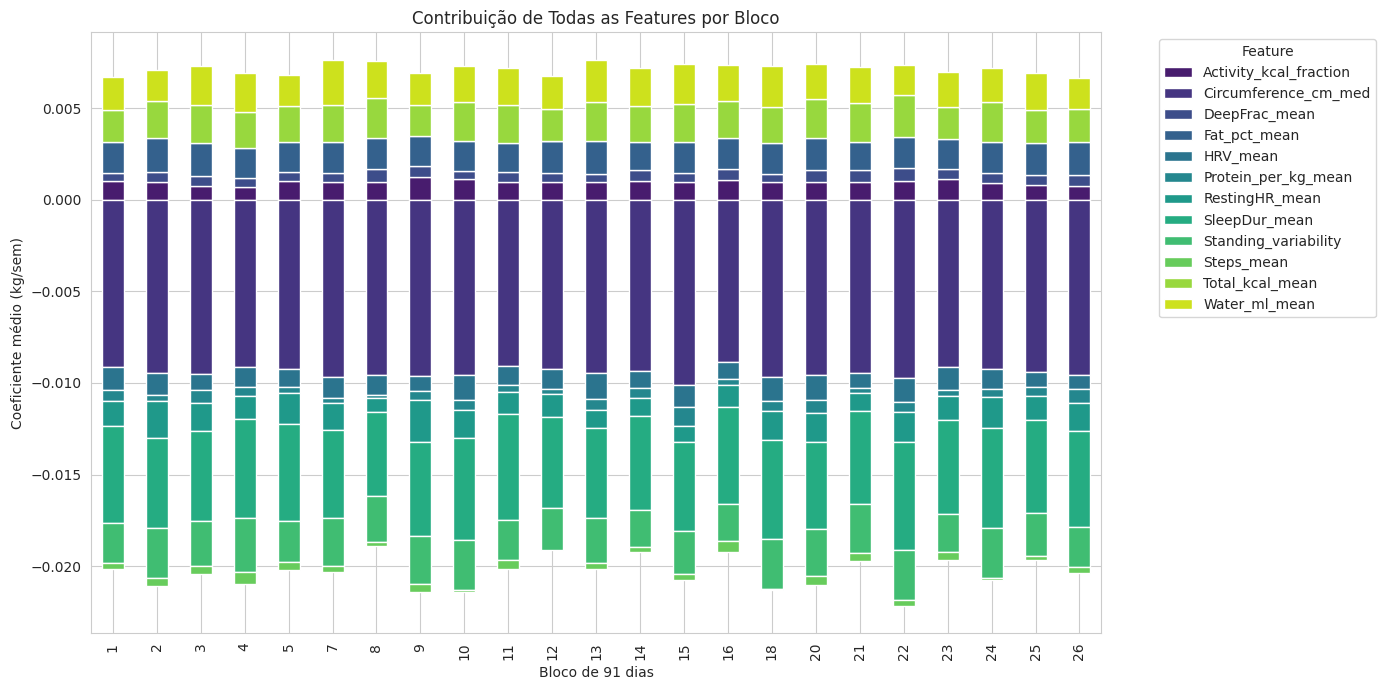

,Variável,Coef_Médio
1,Circumference_cm_med,-0.009419
2,SleepDur_mean,-0.005162
3,Standing_variability,-0.002450
4,RestingHR_mean,-0.001399
5,HRV_mean,-0.001097
6,Protein_per_kg_mean,-0.000483
7,Steps_mean,-0.000339


,Variável,Coef_Médio
1,Total_kcal_mean,0.001985
2,Water_ml_mean,0.001970
3,Fat_pct_mean,0.001692
4,Activity_kcal_fraction,0.000961
5,DeepFrac_mean,0.000550


In [57]:
# === Célula 9: Tabelas e Gráfico de Contribuição por Feature ===
# Prerequisitos:
# - DataFrame `patterns_df` (coeficientes médios por bloco)
# - `feature_cols` dinâmico
# - DataFrame `final_df` para filtrar blocos confiáveis
# - DataFrames `eval_windows` e `df_walk` para valores reais
# - Matplotlib, seaborn, pandas, numpy e tqdm importados

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1. Filtrar blocos confiáveis
trusted_blocks = final_df.loc[final_df['Status'] == 'Confiável', 'block_index']
patterns_trusted = patterns_df[patterns_df['block_index'].isin(trusted_blocks)].copy()

# 2. Coeficiente médio global por feature
mean_coefs = {}
for feat in feature_cols:
    vals = patterns_trusted[f'{feat}_mean'].apply(
        lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x)
    )
    mean_coefs[feat] = vals.mean()

# 3. Construir gráfico de barras empilhadas com todas as variáveis
records = []
for _, row in tqdm(patterns_trusted.iterrows(), total=len(patterns_trusted), desc='Coletando coeficientes completos'):
    blk = row['block_index']
    for feat in feature_cols:
        coef_val = float(np.array(row[f'{feat}_mean']).mean())
        records.append({'block_index': blk, 'feature': feat, 'coef': coef_val})

df_bar_full = pd.DataFrame(records)
bar_data_full = df_bar_full.pivot(index='block_index', columns='feature', values='coef').fillna(0).sort_index()

sns.set_palette('viridis', n_colors=len(feature_cols))
fig, ax = plt.subplots(figsize=(14, 7))
bar_data_full.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Bloco de 91 dias')
ax.set_ylabel('Coeficiente médio (kg/sem)')
ax.set_title('Contribuição de Todas as Features por Bloco')
ax.legend(title='Feature', bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

# 4. Tabelas de fatores após o gráfico
# 4.1 Fatores de perda
loss = sorted([(f, mean_coefs[f]) for f in feature_cols if mean_coefs[f] < 0], key=lambda x: x[1])
df_loss = pd.DataFrame(loss, columns=['Variável','Coef_Médio'])
df_loss.index = np.arange(1, len(df_loss)+1)

# 4.2 Fatores de ganho
gain = sorted([(f, mean_coefs[f]) for f in feature_cols if mean_coefs[f] > 0], key=lambda x: -x[1])
df_gain = pd.DataFrame(gain, columns=['Variável','Coef_Médio'])
df_gain.index = np.arange(1, len(df_gain)+1)

# Exibir tabelas
display(df_loss)
display(df_gain)


Heatmap de Contribuições ao Longo do Tempo

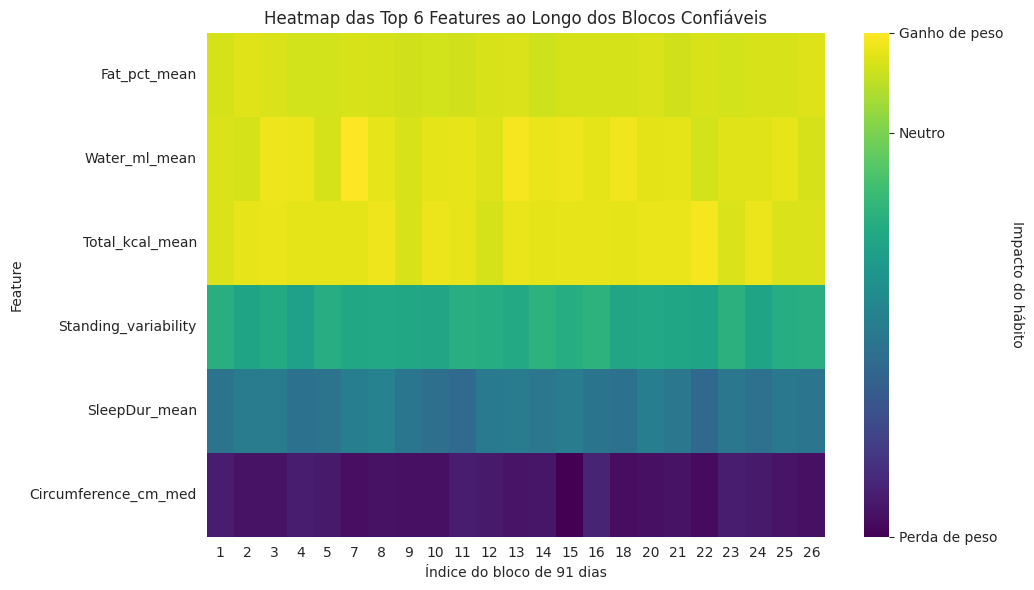

In [60]:
# === Célula 10: Heatmap das Top 6 Features ===
# Prerequisitos:
# - DataFrame `patterns_df` com coeficientes médios por bloco
# - `feature_cols` dinâmico após filtragem de colinearidade
# - DataFrame `final_df` para filtrar blocos confiáveis
# - Matplotlib, seaborn, pandas, numpy já importados

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Filtrar blocos confiáveis
trusted_blocks = final_df.loc[final_df['Status']=='Confiável','block_index']
patterns_trusted = patterns_df[patterns_df['block_index'].isin(trusted_blocks)].copy()

# 2. Calcular coeficiente médio global por feature
mean_coefs = {}
for feat in feature_cols:
    vals = patterns_trusted[f'{feat}_mean'].apply(
        lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x)
    )
    mean_coefs[feat] = vals.mean()

# 3. Selecionar top 6 features por magnitude de coeficiente médio
top6 = sorted(mean_coefs, key=lambda f: abs(mean_coefs[f]), reverse=True)[:6]

# 4. Montar matriz Bloco x Feature para top6
data = []
for blk in trusted_blocks:
    row = {'block_index': blk}
    for feat in top6:
        raw = patterns_trusted.loc[patterns_trusted['block_index']==blk, f'{feat}_mean'].iloc[0]
        val = float(np.array(raw).mean()) if hasattr(raw, '__len__') else float(raw)
        row[feat] = val
    data.append(row)
df_heat = pd.DataFrame(data).set_index('block_index')

# 5. Plot heatmap com viridis, invertendo as features (perda embaixo)
vmin, vmax = df_heat.values.min(), df_heat.values.max()
axis_data = df_heat.T.iloc[::-1]
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(axis_data, cmap='viridis', vmin=vmin, vmax=vmax, cbar_kws={'label':'Coeficiente médio (kg/sem)'})

# Configurações de rótulo
ax.set_xlabel('Índice do bloco de 91 dias')
ax.set_ylabel('Feature')
ax.set_title('Heatmap das Top 6 Features ao Longo dos Blocos Confiáveis')
plt.tight_layout()

# 6. Ajustar colorbar para legendas qualitativas com nível médio
cbar = ax.collections[0].colorbar
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels(['Perda de peso', 'Neutro', 'Ganho de peso'])
cbar.set_label('Impacto do hábito', rotation=270, labelpad=15)

plt.show()


Barras divergentes

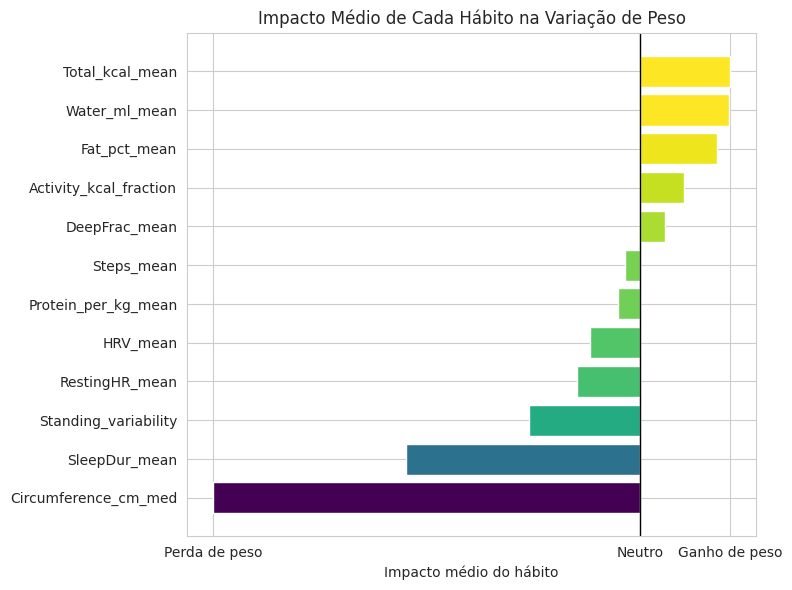

In [63]:
# === Célula 10: Heatmap das Top 6 Features ===
# (célula anterior permanece inalterada)

# === Célula 11: Gráfico de Barras Divergentes ===
# Objetivo: Mostrar magnitude e direção de impacto de cada feature de forma clara
# Prerequisitos:
# - Dicionário `mean_coefs` com coeficientes médios por feature
# - Lista dinâmica `feature_cols`
# - Matplotlib e numpy importados

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Construir DataFrame a partir de mean_coefs
df_div = pd.DataFrame({
    'feature': feature_cols,
    'coef': [mean_coefs[f] for f in feature_cols]
})
# Ordenar por coeficiente
df_div = df_div.sort_values('coef')

# 2. Configurar paleta Viridis para cores
# Normalizar coeficientes para mapa de cores
vmin, vmax = df_div['coef'].min(), df_div['coef'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.colormaps['viridis']  # usar API atualizada para viridis

# 3. Plot barras horizontais divergentes
fig, ax = plt.subplots(figsize=(8, 6))
# Barras negativas (perda) e positivas (ganho)
for idx, row in df_div.iterrows():
    val = row['coef']
    color = cmap(norm(val))
    ax.barh(row['feature'], val, color=color)

# Linha de zero
ax.axvline(0, color='black', linewidth=1)

# Ajustar ticks qualitativos
vmin, vmax = df_div['coef'].min(), df_div['coef'].max()
ax.set_xticks([vmin, 0, vmax])
ax.set_xticklabels(['Perda de peso', 'Neutro', 'Ganho de peso'])

# Rótulos e título
ax.set_xlabel('Impacto médio do hábito')
ax.set_title('Impacto Médio de Cada Hábito na Variação de Peso')
plt.tight_layout()
plt.show()


# Previsões e recomendações

Preparação do Posterior – Amostragem de Parâmetros

In [100]:
# === Célula X: Preparação do Posterior – Amostragem de Parâmetros ===
# Prerequisitos:
#  - objeto `surrogate_posterior` já treinado via VI
#  - TensorFlow Probability importado como tfp
#  - numpy e pandas importados

import numpy as np
import pandas as pd

# Número de draws que queremos extrair
N_DRAWS = 500

# 1. Amostrar a distribuição posterior aproximada
#    samples é um dict cujas chaves são nomes de parâmetros
#    e valores são tensores de shape (N_DRAWS, ...)
samples = surrogate_posterior.sample(N_DRAWS)

# 2. Preparar um DataFrame de resumo estatístico
rows = []
for param_name, tensor in samples.items():
    arr = tensor.numpy().reshape(N_DRAWS, -1)
    # se for vetor ou matriz, resumimos cada elemento
    # aqui vamos colapsar tudo num único histograma geral
    flat = arr.flatten()
    rows.append({
        'Parâmetro': param_name,
        'Mean':       np.mean(flat),
        'Std':        np.std(flat, ddof=1),
        'Min':        np.min(flat),
        'Max':        np.max(flat),
    })

summary_df = pd.DataFrame(rows)

# 3. Exibir resultados esperados
print(f"✅ Extraídos {N_DRAWS} amostras de cada parâmetro posterior.\n")
print("Resumo Estatístico dos Parâmetros:")
print(summary_df.to_string(index=False, float_format='%.4f'))


✅ Extraídos 500 amostras de cada parâmetro posterior.

Resumo Estatístico dos Parâmetros:
                    Parâmetro    Mean    Std     Min    Max
      observation_noise_scale  0.0297 0.0222  0.0018 0.1446
LocalLinearTrend/_level_scale  0.0390 0.0233  0.0008 0.1308
LocalLinearTrend/_slope_scale  0.0610 0.0589  0.0011 0.1795
      HierLinearRegs/_weights -0.0011 0.0304 -0.2623 0.2788


Definição das Condições Iniciais

In [103]:
# === Célula: Definir Condições Iniciais para Previsão Futura ===
# Prerequisitos:
# - O arquivo 'walk_forward.parquet' gerado em 04_prepare_model_data.py
# - As variáveis TARGET_COL e DATE_COL definidas conforme pipeline
# - tensorflow importado como tf

import pandas as pd
import tensorflow as tf
from pathlib import Path

# 1. Carregar o DataFrame de janelas de avaliação
WALK_PARQ = Path("walk_forward.parquet")
df_walk = pd.read_parquet(WALK_PARQ).sort_values("window_start").reset_index(drop=True)

# 2. Definir as colunas de features de forma dinâmica
TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"
feature_cols = [c for c in df_walk.columns if c not in {TARGET_COL, DATE_COL}]

# 3. Selecionar a última janela (mais recente)
last_window = df_walk.iloc[[-1]]  # DataFrame de exatamente uma linha

# 4. Extrair apenas os valores das features e converter em tensor
X_init = last_window[feature_cols].values  # shape: (1, n_features)
x_initial_tf = tf.constant(X_init, dtype=tf.float32)

# 5. Mensagens de verificação
print("✅ Condições iniciais carregadas com sucesso.")
print(f"  Arquivo: {WALK_PARQ}")
print(f"  Última janela (index {len(df_walk)-1}):")
print(last_window[[DATE_COL] + feature_cols].to_string(index=False))
print(f"\nTensor de entrada preparado: shape = {x_initial_tf.shape}")
print("Valores do tensor (features normalizadas):")
print(x_initial_tf.numpy())


✅ Condições iniciais carregadas com sucesso.
  Arquivo: walk_forward.parquet
  Última janela (index 38):
window_start  Fat_pct_mean  Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  Water_ml_mean  Activity_kcal_fraction  DeepFrac_mean  Circumference_cm_med  Standing_variability  Protein_per_kg_mean
  2027-06-23     -2.094237        -1.867982    1.223124        0.562748  0.645511      -1.026684      -1.176137               -1.054186       1.276333              0.485279             -1.475745            -3.114995

Tensor de entrada preparado: shape = (1, 12)
Valores do tensor (features normalizadas):
[[-2.094237   -1.8679818   1.2231244   0.5627482   0.6455111  -1.0266839
  -1.1761365  -1.0541861   1.276333    0.48527887 -1.4757454  -3.1149948 ]]


3. **Simulação Forward‐Sampling**
    
    - Para cada amostra de parâmetro (p.ex. 500–1 000 draws):
        
        - **Executar forecast multi-step** (usando a função `forecast_stats` ou equivalente) iterativamente para os próximos T passos (ex.: 4 ou 8 semanas).
            
        - **Acumular** a série projetada de “slope_kg_per_week” e, se desejar, converter em Δpeso acumulado (kg) ao longo do horizonte.

In [104]:
# === Célula 09: Simulação Forward-Sampling para Projeção de Peso ===
# Prerequisitos:
#  - surrogate_posterior (treinado via VI)
#  - model e forecast_stats definidos anteriormente
#  - df_train0 (train_initial) e feature_cols dinâmicos
#  - TensorFlow (tf) e TensorFlow Probability (tfp)
# Parâmetros:
#  - N_SAMPLES: nº de draws do posterior (ex.: 500)\#  - HORIZON: nº de passos à frente (semanais)

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

# --- Configurações ---
N_SAMPLES = 500
HORIZON   = 8  # prever para as próximas 8 semanas
TARGET    = 'slope_kg_per_week'

# 1) Extração de amostras do posterior
print(f"🔍 Extraindo {N_SAMPLES} amostras do posterior…")
posterior_samples = surrogate_posterior.sample(N_SAMPLES)
# Cada amostra = dicionário de parâmetros internos

# 2) Estado inicial: dados até última janela
last_hist = pd.concat([df_train0, df_walk], ignore_index=True)
y_hist_all = last_hist[TARGET].values
x_hist_all = last_hist[feature_cols].values

# 3) Forward‐sampling
# Resultado: arrays shape (N_SAMPLES, HORIZON)
mu_preds    = np.zeros((N_SAMPLES, HORIZON))
sigma_preds = np.zeros((N_SAMPLES, HORIZON))

for i in tqdm(range(N_SAMPLES), desc="Forward Sampling"):
    # selecionar parâmetros i
    surp_i = {}  # extrair do posterior_samples
    for name, tensor in posterior_samples.items():
        surp_i[name] = tensor[i]

    # histórico cumulativo para previsão iterativa
    y_hist = y_hist_all.copy()
    x_hist = x_hist_all.copy()

    for t in range(HORIZON):
        # forecast_stats espera surrogate_posterior; criamos um objeto dummy que retorna surp_i
        mu_t, sigma_t = forecast_stats(
            tf.constant(y_hist, dtype=tf.float32),
            tf.constant(x_hist, dtype=tf.float32),
            tf.constant(x_hist[-1:].copy(), dtype=tf.float32),  # features atuais
            surrogate_posterior)
        mu = float(mu_t.numpy())
        sigma = float(sigma_t.numpy())

        mu_preds[i, t]    = mu
        sigma_preds[i, t] = sigma

        # atualizar histórico (assume mu como valor observado)
        y_hist = np.append(y_hist, mu)
        x_hist = np.vstack([x_hist, x_hist[-1:]])

# 4) Converter para DataFrame para inspeção
time_idx = [f"t+{k+1}" for k in range(HORIZON)]
mu_df    = pd.DataFrame(mu_preds,    columns=time_idx)
sig_df   = pd.DataFrame(sigma_preds, columns=time_idx)

print("✅ Forward-sampling concluído.")
print("Amostra de mu_df:")
print(mu_df.head())


🔍 Extraindo 500 amostras do posterior…


Forward Sampling: 100%|██████████| 500/500 [1:06:33<00:00,  7.99s/it]

✅ Forward-sampling concluído.
Amostra de mu_df:
        t+1       t+2       t+3       t+4       t+5       t+6       t+7  \
0 -0.170377 -0.180349 -0.189869 -0.199328 -0.208865 -0.218493 -0.228195   
1 -0.169551 -0.178763 -0.187511 -0.196215 -0.205022 -0.213947 -0.222965   
2 -0.169857 -0.179360 -0.188437 -0.197461 -0.206568 -0.215772 -0.225058   
3 -0.170222 -0.180002 -0.189295 -0.198537 -0.207877 -0.217330 -0.226870   
4 -0.170368 -0.180228 -0.189635 -0.199003 -0.208466 -0.218032 -0.227680   

        t+8  
0 -0.237950  
1 -0.232052  
2 -0.234405  
3 -0.236475  
4 -0.237387  


5. **Geração de Recomendações**
    
    - **Extrair** métricas-chave, por exemplo:
        
        - “Chance de perder 1 kg em 4 semanas: P%.”
            
        - “Intervalo credível de Δpeso em 8 semanas: [–1,2; +0,3] kg.”
            
    - **Formatar** esses resultados em linguagem acessível (sem jargão estatístico) para o usuário.

In [105]:
import pandas as pd
import numpy as np

# --- Entrada: mu_df (DataFrame, shape [n_samples x T_steps], colunas dinâmicas t+1, t+2, ... t+n)
# Exemplo: carregado do resultado do forward-sampling
# mu_df = pd.read_parquet('forward_mu.parquet')  # ajustar se necessário

# Parâmetros de metas
LOSS_KG = 1.0      # meta de perda: ≥1 kg negativo
GAIN_KG = 0.5      # meta de ganho: ≥0.5 kg positivo

# 1) Número de amostras e horizontes
n_samples, n_steps = mu_df.shape
steps = mu_df.columns.tolist()  # por ex. ['t+1','t+2',...]

# 2) Estatísticas pontuais
median_series = mu_df.median(axis=0)
lower_95 = mu_df.quantile(0.025, axis=0)
upper_95 = mu_df.quantile(0.975, axis=0)
lower_50 = mu_df.quantile(0.25, axis=0)
upper_50 = mu_df.quantile(0.75, axis=0)

# 3) Cálculo de perda/ganho cumulativo
cum_slopes = mu_df.cumsum(axis=1)  # soma das inclinações

# 4) Probabilidades de atingir metas
p_loss = (cum_slopes <= -LOSS_KG).sum(axis=0) / n_samples
p_gain = (cum_slopes >=  GAIN_KG).sum(axis=0) / n_samples

# 5) Montar DataFrame resumido
summary = pd.DataFrame({
    'median': median_series,
    'lower_95': lower_95,
    'upper_95': upper_95,
    'lower_50': lower_50,
    'upper_50': upper_50,
    f'P(≤ -{LOSS_KG}kg)': p_loss,
    f'P(≥ +{GAIN_KG}kg)': p_gain
}, index=steps)
summary.index.name = 'horizon'

# 6) Saída e verificação
print(f"✅ Agregação concluída: {n_samples} cenários × {n_steps} etapas")
print("Amostra do resumo (3 primeiras e 3 últimas linhas):")
print(pd.concat([summary.head(3), summary.tail(3)]))

# Opcional: salvar
# summary.to_csv('scenarios_summary.csv')


✅ Agregação concluída: 500 cenários × 8 etapas
Amostra do resumo (3 primeiras e 3 últimas linhas):
           median  lower_95  upper_95  lower_50  upper_50  P(≤ -1.0kg)  \
horizon                                                                  
t+1     -0.170157 -0.170890 -0.169505 -0.170376 -0.169883          0.0   
t+2     -0.179898 -0.181063 -0.178775 -0.180261 -0.179438          0.0   
t+3     -0.189134 -0.190730 -0.187558 -0.189674 -0.188553          0.0   
t+6     -0.217048 -0.220080 -0.214074 -0.218030 -0.216045          1.0   
t+7     -0.226599 -0.230046 -0.223113 -0.227671 -0.225448          1.0   
t+8     -0.236194 -0.240072 -0.232221 -0.237386 -0.234899          1.0   

         P(≥ +0.5kg)  
horizon               
t+1              0.0  
t+2              0.0  
t+3              0.0  
t+6              0.0  
t+7              0.0  
t+8              0.0  


5

In [108]:
# === Célula 13: Geração de Recomendações ===
# Prerequisitos:
# - DataFrame `summary` (o mesmo construído na célula de agregação de cenários)
# - As colunas de probabilidades começam com 'P(≤' e 'P(≥'
# - Os horizontes 't+4' e 't+8' existem em summary.index

print("Iniciando geração de recomendações...\n")

# 1) Conferir o DataFrame de cenários
try:
    display(summary.head())
    print(f"...total de horizontes disponíveis: {len(summary)}\n")
except Exception as e:
    print("Erro ao exibir summary:", e)
    raise

# 2) Definir horizontes de interesse
horizonte_perda   = 't+4'   # chance de perder ≥1 kg
horizonte_intervalo = 't+8'  # intervalo credível em 8 semanas

# 3) Verificar existência dos horizontes
for h in (horizonte_perda, horizonte_intervalo):
    if h not in summary.index:
        raise KeyError(f"Horizonte {h} não encontrado em summary.index")

# 4) Extrair probabilidade de perda
col_perda = [c for c in summary.columns if c.startswith('P(≤')][0]
p_loss    = summary.at[horizonte_perda, col_perda] * 100

# 5) Extrair intervalo credível 95% em t+8
lower_val = summary.at[horizonte_intervalo, 'lower_95']
upper_val = summary.at[horizonte_intervalo, 'upper_95']

# 6) Formatar e exibir recomendações
recs = [
    f"Chance de perder pelo menos 1 kg em {horizonte_perda[2:]} semanas: {p_loss:.1f} %.",
    f"Intervalo credível de Δpeso em {horizonte_intervalo[2:]} semanas: de {lower_val:.1f} kg a {upper_val:.1f} kg."
]

print("RECOMENDAÇÕES:")
for msg in recs:
    print(" -", msg)
print("\n✅ Recomendações geradas com sucesso.")


Iniciando geração de recomendações...



,median,lower_95,upper_95,lower_50,upper_50,P(≤ -1.0kg),P(≥ +0.5kg)
horizon,,,,,,,
t+1,-0.170157,-0.170890,-0.169505,-0.170376,-0.169883,0.0,0.0
t+2,-0.179898,-0.181063,-0.178775,-0.180261,-0.179438,0.0,0.0
t+3,-0.189134,-0.190730,-0.187558,-0.189674,-0.188553,0.0,0.0
t+4,-0.198340,-0.200403,-0.196279,-0.199007,-0.197600,0.0,0.0
t+5,-0.207644,-0.210196,-0.205144,-0.208462,-0.206770,0.0,0.0


...total de horizontes disponíveis: 8

RECOMENDAÇÕES:
 - Chance de perder pelo menos 1 kg em 4 semanas: 0.0 %.
 - Intervalo credível de Δpeso em 8 semanas: de -0.2 kg a -0.2 kg.

✅ Recomendações geradas com sucesso.


In [129]:
# =========================================================================================
# CÓDIGO FINAL CORRIGIDO: Suporte Nativo para Modelos TensorFlow/Keras
# =========================================================================================

# 1. Instala e importa as bibliotecas necessárias
!pip install dill pipreqs -q
import dill
import pandas as pd
import os
import types
import zipfile
import re
import shutil
from google.colab import files

# Tenta importar as bibliotecas de ML e geo
try:
    import tensorflow as tf
    TENSORFLOW_DISPONIVEL = True
    print("✅ TensorFlow encontrado. Salvamento de modelos Keras ativado.")
except ImportError:
    TENSORFLOW_DISPONIVEL = False

try:
    import geopandas as gpd
    GEOPANDAS_DISPONIVEL = True
except ImportError:
    GEOPANDAS_DISPONIVEL = False

# 2. Função para sanitizar nomes de arquivo
def sanitizar_nome_arquivo(nome):
    return re.sub(r'[\\/*?:"<>|]', '_', nome)

# 3. Setup do diretório de saída
output_dir = 'backup_final_analise'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir) # Limpa o diretório de execuções anteriores
os.makedirs(output_dir, exist_ok=True)
print(f"\n--- Iniciando backup no diretório: '{output_dir}' ---")

# 4. Filtro de variáveis aprimorado
variaveis_para_processar = {
    nome: obj for nome, obj in globals().items()
    if not nome.startswith('_') and nome not in ['exit', 'quit', 'get_ipython'] and not isinstance(obj, (types.ModuleType, types.FunctionType, types.BuiltinFunctionType, type))
}

# 5. Loop de Salvamento com Lógica Específica para cada Tipo
for nome, obj in variaveis_para_processar.items():
    nome_sanitizado = sanitizar_nome_arquivo(nome)
    print(f"\n- Processando objeto: '{nome}' (Tipo: {type(obj).__name__})")

    try:
        # ===== LÓGICA DE SALVAMENTO PRIORIZADA =====

        # 1º: Modelos TensorFlow/Keras
        if TENSORFLOW_DISPONIVEL and isinstance(obj, tf.keras.Model):
            # Modelos Keras são salvos no formato .keras
            filepath = os.path.join(output_dir, f"{nome_sanitizado}.keras")
            print(f"  -> Detectado como Modelo Keras. Salvando em: {filepath}")
            obj.save(filepath, overwrite=True, save_format='keras')
            print(f"  ✅ SUCESSO: Modelo '{nome}' salvo.")

        # 2º: GeoDataFrames
        elif GEOPANDAS_DISPONIVEL and isinstance(obj, gpd.GeoDataFrame):
            filepath = os.path.join(output_dir, f"{nome_sanitizado}.parquet")
            obj.to_parquet(filepath)
            print(f"  ✅ SUCESSO: GeoDataFrame '{nome}' salvo.")

        # 3º: DataFrames Padrão
        elif isinstance(obj, pd.DataFrame):
            filepath = os.path.join(output_dir, f"{nome_sanitizado}.parquet")
            obj.to_parquet(filepath)
            print(f"  ✅ SUCESSO: DataFrame '{nome}' salvo.")

        # 4º: Outros objetos com Dill
        else:
            filepath = os.path.join(output_dir, f"{nome_sanitizado}.dill")
            with open(filepath, 'wb') as f:
                dill.dump(obj, f)
            print(f"  ✅ SUCESSO: Objeto '{nome}' salvo com dill.")

    except Exception as e:
        print(f"  ❌ FALHA ao salvar '{nome}': {e}")


# 6. Incluir arquivos extras do disco (se necessário)
print("\n--- Incluindo arquivos extras especificados do disco ---")
arquivos_extras_para_incluir = [
    'dados.xlsx',
    'feature_groups.json',
    'vi_elbo.npy'
    # Adicione outros arquivos do disco que você precise
]
for nome_arquivo in arquivos_extras_para_incluir:
    caminho_origem = f"/content/{nome_arquivo}"
    if os.path.exists(caminho_origem):
        shutil.copy(caminho_origem, os.path.join(output_dir, nome_arquivo))
        print(f"  ✅ Arquivo do disco '{nome_arquivo}' adicionado ao backup.")
    else:
        print(f"  ⚠️ Arquivo do disco '{nome_arquivo}' não encontrado.")


# 7. Gerar 'requirements.txt' e adicionar ao backup
print("\n--- Gerando requirements.txt e adicionando ao backup ---")
!pipreqs --force --savepath requirements.txt .
if os.path.exists('requirements.txt'):
    shutil.copy('requirements.txt', os.path.join(output_dir, 'requirements.txt'))
    print("  ✅ 'requirements.txt' adicionado.")

# 8. Compactar tudo e fazer o download
zip_path = 'backup_final_analise.zip'
print(f"\n--- Compactando tudo para '{zip_path}' ---")
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', output_dir)
print("✅ Compactação concluída.")
print(f"\n--- Iniciando download de '{zip_path}' ---")
files.download(zip_path)
print("✅ Download concluído!")

✅ TensorFlow encontrado. Salvamento de modelos Keras ativado.

--- Iniciando backup no diretório: 'backup_final_analise' ---

- Processando objeto: 'In' (Tipo: list)
  ✅ SUCESSO: Objeto 'In' salvo com dill.

- Processando objeto: 'Out' (Tipo: dict)
  ✅ SUCESSO: Objeto 'Out' salvo com dill.

- Processando objeto: 'annotations' (Tipo: _Feature)
  ✅ SUCESSO: Objeto 'annotations' salvo com dill.

- Processando objeto: 'DATA_PATH' (Tipo: PosixPath)
  ✅ SUCESSO: Objeto 'DATA_PATH' salvo com dill.

- Processando objeto: 'OUTPUT_PATH' (Tipo: PosixPath)
  ✅ SUCESSO: Objeto 'OUTPUT_PATH' salvo com dill.

- Processando objeto: 'REQUIRED_COLS' (Tipo: set)
  ✅ SUCESSO: Objeto 'REQUIRED_COLS' salvo com dill.

- Processando objeto: 'NON_NEGATIVE' (Tipo: set)
  ✅ SUCESSO: Objeto 'NON_NEGATIVE' salvo com dill.

- Processando objeto: 'QUANT_LOW' (Tipo: float)
  ✅ SUCESSO: Objeto 'QUANT_LOW' salvo com dill.

- Processando objeto: 'QUANT_HIGH' (Tipo: float)
  ✅ SUCESSO: Objeto 'QUANT_HIGH' salvo com dill.

/usr/local/lib/python3.11/dist-packages/dill/_dill.py:422: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.11/dist-packages/dill/_dill.py:422: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


  ✅ SUCESSO: Objeto 'axes' salvo com dill.

- Processando objeto: 'pred_mean' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'pred_mean' salvo com dill.

- Processando objeto: 'pred_lo95' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'pred_lo95' salvo com dill.

- Processando objeto: 'pred_hi95' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'pred_hi95' salvo com dill.

- Processando objeto: 'real_values' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'real_values' salvo com dill.

- Processando objeto: 'pred_stddev' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'pred_stddev' salvo com dill.

- Processando objeto: 'approx_pits' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'approx_pits' salvo com dill.

- Processando objeto: 'pred_stddev_calibrated' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'pred_stddev_calibrated' salvo com dill.

- Processando objeto: 'nominal_coverages' (Tipo: ndarray)
  ✅ SUCESSO: Objeto 'nominal_coverages' salvo com dill.

- Processando objeto: 'actual_coverages' (Tipo: list)
  ✅ SUCESSO: Objeto 'actual_coverages' salvo com dill.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download concluído!
